# **Background & Business Understanding**
## **Background** 

---

[LendingClub](https://www.lendingclub.com/) is a USA peer-to-peer lending company, headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform.

When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. Two types of risks are associated with the bank’s decision:

*   If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company
*   If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company

## **Business Understanding** 
When a person applies for a loan, there are two types of decisions that could be taken by the company:

**Loan accepted:** If the company approves the loan, there are 3 possible scenarios described below:

1.   Fully paid: Applicant has fully paid the loan (the principal and the interest rate)
2.   Charged-off: Applicant has not paid the instalments in due time for a long period of time, i.e. he/she has defaulted on the loan

**Loan rejected:** The company had rejected the loan (because the candidate does not meet their requirements etc.). Since the loan was rejected, there is no transactional history of those applicants with the company and so this data is not available with the company (and thus in this dataset)

#**Problem Statement**
##**Goal**
Create a credit scoring model to detect the most suitable customers to get the loan

##**Research question** 
What type of model is most suitable for determining good borrowers?

#**Assumption and Data**
##**Assumption** 
This study used commonly models in financial industry called Predict of Defaults (PD). The final goals not only created a suitable model but also create a scorecard to filter whether a borrower is good borrower or bad borrower.

##**Data**
This study utilized data from [Kaggle](https://www.kaggle.com/datasets/husainsb/lendingclub-issued-loans). 

In [1]:
#Essentials
import numpy as np
import pandas as pd

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#Model
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_recall_curve,  
    roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve)
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import f_classif

#Misc
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import Dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import data.
loan_data_backup = pd.read_csv('/content/drive/MyDrive/loan_data_project/lc_loan.csv')

In [4]:
loan_data = loan_data_backup.copy()

In [5]:
pd.options.display.max_columns = None
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Data Understanding

---

<table>
  <tr>
    <th>Features</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>loan_amnt</td>
    <td>The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value</td>
  </tr>
  <tr>
    <td>term</td>
    <td>The number of payments on the loan. Values are in months and can be either 36 or 60</td>
  </tr>
  <tr>
    <td>int_rate</td>
    <td>Interest Rate on the loan</td>
  </tr>
  <tr>
    <td>installment</td>
    <td>The monthly payment owed by the borrower if the loan originates</td>
  </tr>
  <tr>
    <td>grade</td>
    <td>LC assigned loan grade</td>
  </tr>
  <tr>
    <td>sub_grade</td>
    <td>LC assigned loan subgrade</td>
  </tr>
  <tr>
    <td>emp_title</td>
    <td>The job title supplied by the Borrower when applying for the loan</td>
  </tr>
  <tr>
    <td>emp_length</td>
    <td>Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years</td>
  </tr>
  <tr>
    <td>home_ownership</td>
    <td>The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER</td>
  </tr>
  <tr>
    <td>annual_inc</td>
    <td>The self-reported annual income provided by the borrower during registration</td>
  </tr>
  <tr>
    <td>verification_status</td>
    <td>Indicates if income was verified by LC, not verified, or if the income source was verified</td>
  </tr>
  <tr>
    <td>issue_d</td>
    <td>The month which the loan was funded</td>
  </tr>
  <tr>
    <td>loan_status</td>
    <td>Current status of the loan</td>
  </tr>
  <tr>
    <td>purpose</td>
    <td>A category provided by the borrower for the loan request</td>
  </tr>
  <tr>
    <td>title</td>
    <td>The loan title provided by the borrower</td>
  </tr>
  <tr>
    <td>address</td>
    <td>The state provided by the borrower in the loan application</td>
  </tr>
  <tr>
    <td>dti</td>
    <td>A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income</td>
  </tr>
  <tr>
    <td>earliest_cr_line</td>
    <td>The month the borrower's earliest reported credit line was opened</td>
  </tr>
  <tr>
    <td>open_acc</td>
    <td>The number of open credit lines in the borrower's credit file</td>
  </tr>
   <tr>
    <td>pub_rec</td>
    <td>Number of derogatory public records</td>
  </tr>
   <tr>
    <td>revol_bal</td>
    <td>Total credit revolving balance</td>
  </tr>
   <tr>
    <td>revol_util</td>
    <td>Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit</td>
  </tr>
   <tr>
    <td>total_acc</td>
    <td>The total number of credit lines currently in the borrower's credit file</td>
  </tr>
  <tr>
    <td>initial_list_status</td>
    <td>The initial listing status of the loan. Possible values are – W, F</td>
  </tr>
   <tr>
    <td>application_type</td>
    <td>Indicates whether the loan is an individual application or a joint application with two co-borrowers</td>
  </tr>
   <tr>
    <td>mort_acc</td>
    <td>Number of mortgage accounts</td>
  </tr>
   <tr>
    <td>pub_rec_bankruptcies</td>
    <td>Number of public record bankruptcies</td>
  </tr>
</table>

#Exploratory Data Analysis

###Data Exploration

In [7]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

In [8]:
# get a list of columns that have more than 50% null values
na_values = loan_data.isnull().mean()
na_values[na_values>0.5]

desc                           0.857977
mths_since_last_delinq         0.511971
mths_since_last_record         0.845553
mths_since_last_major_derog    0.750160
annual_inc_joint               0.999424
dti_joint                      0.999426
verification_status_joint      0.999424
open_acc_6m                    0.975916
open_il_6m                     0.975916
open_il_12m                    0.975916
open_il_24m                    0.975916
mths_since_rcnt_il             0.976549
total_bal_il                   0.975916
il_util                        0.979020
open_rv_12m                    0.975916
open_rv_24m                    0.975916
max_bal_bc                     0.975916
all_util                       0.975916
inq_fi                         0.975916
total_cu_tl                    0.975916
inq_last_12m                   0.975916
dtype: float64

In [9]:
# drop columns with more than 50% null values
loan_data.dropna(thresh = loan_data.shape[0]*0.5, how = 'all', axis = 1, inplace = True)

In [10]:
#Drop some features that not reliable
'''
drop redundant features like id, member_id, emp_title, title, url, zip_code etc.
drop sub_grade as same information is captured in grade column
drop issue_d as prevent on data leakage
drop pymnt_plan as to many values n 
drop addr_state as assuming models not only used on USA
drop time features as it is not reliable in this time : emp_length, next_pymnt_d, earliest_cr_line, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d 
'''
loan_data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'title', 'zip_code', 'emp_length',
                          'issue_d', 'addr_state', 'next_pymnt_d', 'pymnt_plan', 'earliest_cr_line', 'inq_last_6mths',
                          'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d'], inplace = True)

In [11]:
# Re-explore the df
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   887379 non-null  float64
 1   funded_amnt                 887379 non-null  float64
 2   funded_amnt_inv             887379 non-null  float64
 3   term                        887379 non-null  object 
 4   int_rate                    887379 non-null  float64
 5   installment                 887379 non-null  float64
 6   grade                       887379 non-null  object 
 7   home_ownership              887379 non-null  object 
 8   annual_inc                  887375 non-null  float64
 9   verification_status         887379 non-null  object 
 10  loan_status                 887379 non-null  object 
 11  purpose                     887379 non-null  object 
 12  dti                         887379 non-null  float64
 13  delinq_2yrs   

## Identify the target variable

In [12]:
# explore the unique values in loan_status column
loan_data['loan_status'].value_counts(normalize = True)

Current                                                0.678153
Fully Paid                                             0.234086
Charged Off                                            0.050991
Late (31-120 days)                                     0.013062
Issued                                                 0.009534
In Grace Period                                        0.007047
Late (16-30 days)                                      0.002656
Does not meet the credit policy. Status:Fully Paid     0.002240
Default                                                0.001374
Does not meet the credit policy. Status:Charged Off    0.000858
Name: loan_status, dtype: float64

In [13]:
# create a new column based on the loan_status column that will be our target variable
loan_data['good_bad'] = np.where(loan_data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']), 0, 1)
# Drop the original 'loan_status' column
loan_data.drop(columns = ['loan_status'], inplace = True)

In [118]:
loan_data['good_bad'].value_counts()

1    828560
0     58819
Name: good_bad, dtype: int64

#**Analyzing & Modelling**

##General Data Cleaning

In [14]:
#term
#convert term's values to numeric
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

# Applied to X_train & X_test
loan_term_converter(loan_data, 'term')

In [15]:
#Check the values
loan_data.home_ownership.value_counts()

MORTGAGE    443557
RENT        356117
OWN          87470
OTHER          182
NONE            50
ANY              3
Name: home_ownership, dtype: int64

In [16]:
#Merge the smaller one values, NONE and ANY values to OTHER values
val = ['ANY','NONE']
loan_data['home_ownership'] = loan_data['home_ownership'].replace(val, 'OTHER')

In [17]:
#Recheck the values
loan_data.home_ownership.value_counts()

MORTGAGE    443557
RENT        356117
OWN          87470
OTHER          235
Name: home_ownership, dtype: int64

##Dataset Splitting

In [18]:
X = loan_data.drop('good_bad', axis = 1)
y = loan_data['good_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

##Featured Selection 

In [19]:
# first divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

###Chi-squared statistic for categorical features

In [20]:
from scipy.stats import chi2_contingency

# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,grade,0.000000e+00
1,home_ownership,0.000000e+00
2,verification_status,0.000000e+00
3,purpose,0.000000e+00
4,initial_list_status,0.000000e+00
5,application_type,5.740000e-07


Let's keep only the top four categorical features

###ANOVA F-Statistic for numerical features

In [21]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,recoveries,152420.452866,0.000000e+00
1,collection_recovery_fee,64999.815107,0.000000e+00
2,out_prncp,24863.355513,0.000000e+00
3,out_prncp_inv,24862.392709,0.000000e+00
4,int_rate,20508.435065,0.000000e+00
5,total_rec_late_fee,17522.702545,0.000000e+00
6,total_rec_prncp,6324.529973,0.000000e+00
7,total_rec_int,2346.839337,0.000000e+00
8,revol_util,1473.995166,0.000000e+00
9,total_pymnt_inv,1307.336345,0.000000e+00


For the sake of simplicity, we will keep only the top 20 features and calculate pair-wise correlations between them

###Pearson Correlation

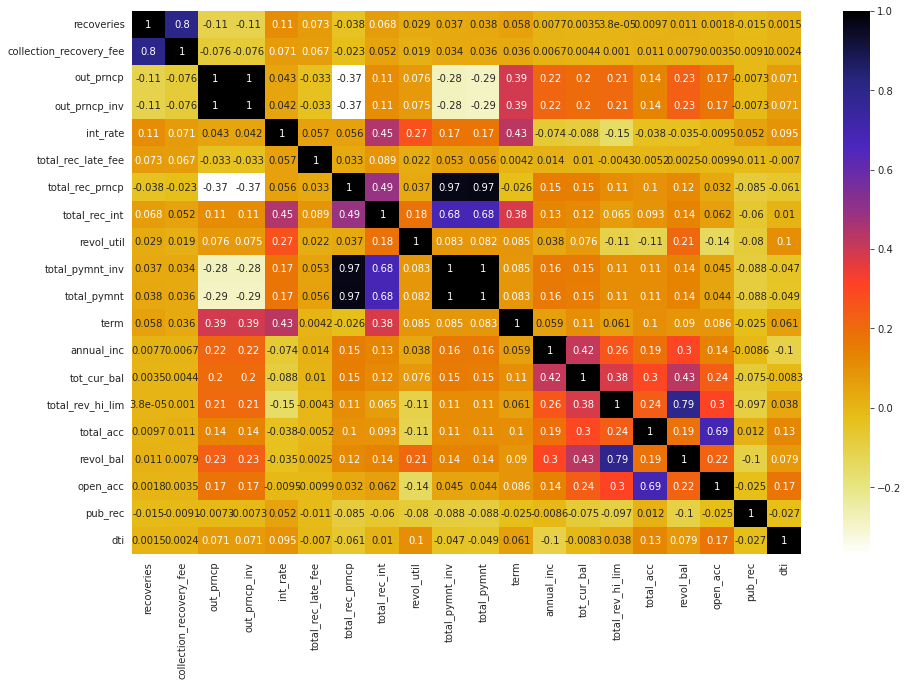

In [22]:
# save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:20,0].to_list()
# calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corrmat, cmap=plt.cm.CMRmap_r,annot=True)
plt.show()

The following features can also be safely dropped given their multicollinearity with other features:
- total_pymnt_inv
- collection_recovery_fee
- out_prncp_inv
- total_rev_hi_lim


In [23]:
# Define a helper function to drop the 4 categorical features with least p-values for chi squared test, 14 numerical features with least F-Statistic
# and 2 numerical features with high multicollinearity
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(['collection_recovery_fee', 'out_prncp_inv', 'total_rev_hi_lim', 'total_pymnt_inv'])

In [24]:
def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

# apply to X_train & X_test
col_to_drop(X_train, drop_columns_list)
col_to_drop(X_test, drop_columns_list)

## Create Dummy Variable

In [25]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to our final four categorical variables
X_train = dummy_creation(X_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])
X_test = dummy_creation(X_test, ['grade', 'home_ownership', 'verification_status', 'purpose'])

In [26]:
# reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set
X_test_data = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

##Analyze WoEs and IVs of discrete features

In this process, the data will be grouped based on the value of each feature. For numerical features, the data will be grouped into 50 classes. After that, the values will be binned based on WoE values ​​and the small of amount data will be merged into the others data value. For features that have an IV score of less than 0.02, they will not be used in the model.

In [27]:
# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

In [28]:
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [29]:
# We set the default style of the graphs to the seaborn style. 
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)   

In [30]:
#term
term_temp = woe_discrete(X_train_prepr, 'term', y_train_prepr)
term_temp

,term,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,60,213168,0.919533,0.300278,196015.0,17153.0,0.295716,0.364531,-0.209210,NaN,NaN,0.021472
1,36,496735,0.939803,0.699722,466833.0,29902.0,0.704284,0.635469,0.102818,0.02027,0.312028,0.021472


In [31]:
#grade
grade_temp = woe_discrete(X_train_prepr, 'grade', y_train_prepr)
grade_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,4352,0.792050,0.006130,3447.0,905.0,0.005200,0.019233,-1.307904,NaN,NaN,0.32531
1,F,18464,0.832160,0.026009,15365.0,3099.0,0.023180,0.065859,-1.044216,0.040110,0.263688,0.32531
2,E,56534,0.879931,0.079636,49746.0,6788.0,0.075049,0.144257,-0.653455,0.047771,0.390761,0.32531
3,D,111715,0.899969,0.157367,100540.0,11175.0,0.151679,0.237488,-0.448352,0.020038,0.205103,0.32531
4,C,196876,0.933207,0.277328,183726.0,13150.0,0.277177,0.279460,-0.008205,0.033238,0.440147,0.32531
5,B,203332,0.953726,0.286422,193923.0,9409.0,0.292560,0.199957,0.380566,0.020519,0.388771,0.32531
6,A,118630,0.978682,0.167107,116101.0,2529.0,0.175155,0.053746,1.181408,0.024956,0.800842,0.32531


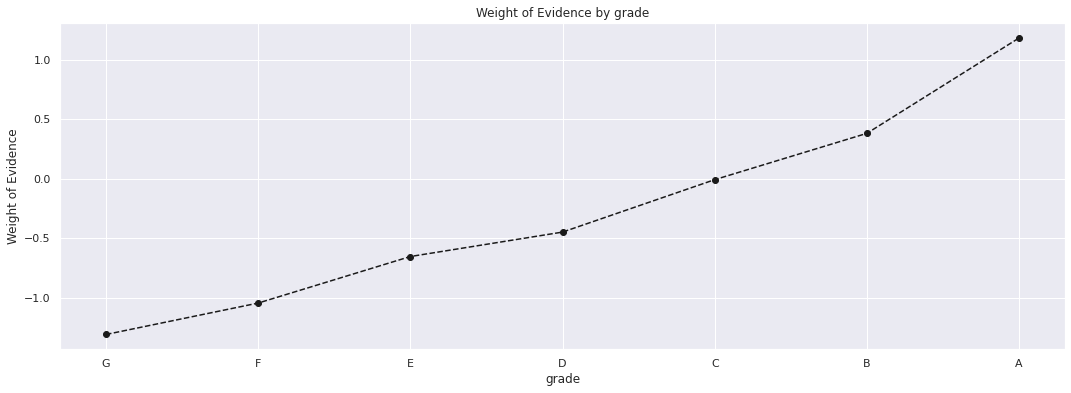

In [32]:
plot_by_woe(grade_temp)

In [33]:
#home_ownership
home_own_temp = woe_discrete(X_train_prepr, 'home_ownership', y_train_prepr)
home_own_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,197,0.802030,0.000278,158.0,39.0,0.000238,0.000829,-1.246195,NaN,NaN,0.023215
1,RENT,284809,0.922415,0.401194,262712.0,22097.0,0.396338,0.469599,-0.169612,0.120384,1.076583,0.023215
2,OWN,69993,0.937965,0.098595,65651.0,4342.0,0.099044,0.092275,0.070789,0.015551,0.240401,0.023215
3,MORTGAGE,354904,0.942021,0.499933,334327.0,20577.0,0.504380,0.437297,0.142717,0.004056,0.071928,0.023215


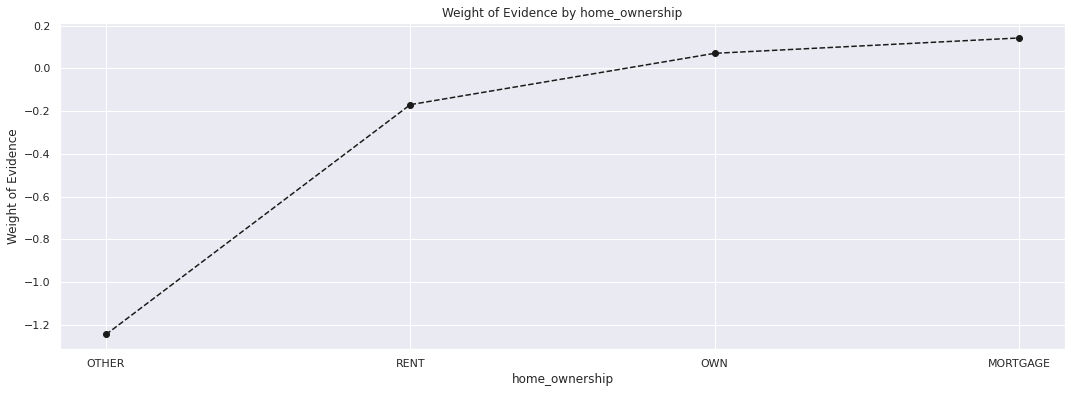

In [34]:
plot_by_woe(home_own_temp)

In [35]:
#Sum some values: OTHER, NONE, ANY cause have a little n values to home_ownership:RENT
X_train_prepr['home_ownership:RENT_OTHER'] = sum([X_train_prepr['home_ownership:RENT'], X_train_prepr['home_ownership:OTHER']])

In [36]:
#verification_status
ver_temp = woe_discrete(X_train_prepr, 'verification_status', y_train_prepr)
ver_temp

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,232882,0.916151,0.328048,213355.0,19527.0,0.321876,0.414982,-0.254069,NaN,NaN,0.03741
1,Not Verified,213048,0.942135,0.300109,200720.0,12328.0,0.302815,0.261991,0.144809,0.025984,0.398878,0.03741
2,Source Verified,263973,0.942418,0.371844,248773.0,15200.0,0.375309,0.323026,0.150017,0.000283,0.005208,0.03741


In [37]:
#purpose
purpose_temp = woe_discrete(X_train_prepr, 'purpose', y_train_prepr)
purpose_temp

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,educational,343,0.787172,0.000483,270.0,73.0,0.000407,0.001551,-1.337266,NaN,NaN,0.049752
1,small_business,8260,0.842857,0.011635,6962.0,1298.0,0.010503,0.027585,-0.965586,0.055685,0.371680,0.049752
2,wedding,1893,0.880085,0.002667,1666.0,227.0,0.002513,0.004824,-0.651998,0.037227,0.313589,0.049752
3,renewable_energy,458,0.882096,0.000645,404.0,54.0,0.000609,0.001148,-0.632798,0.002012,0.019200,0.049752
4,moving,4304,0.899164,0.006063,3870.0,434.0,0.005838,0.009223,-0.457263,0.017067,0.175534,0.049752
5,house,2945,0.902207,0.004148,2657.0,288.0,0.004008,0.006120,-0.423236,0.003044,0.034027,0.049752
6,medical,6873,0.912265,0.009682,6270.0,603.0,0.009459,0.012815,-0.303614,0.010058,0.119622,0.049752
7,other,34299,0.912505,0.048315,31298.0,3001.0,0.047217,0.063776,-0.300620,0.000239,0.002994,0.049752
8,vacation,3782,0.924379,0.005327,3496.0,286.0,0.005274,0.006078,-0.141846,0.011874,0.158774,0.049752
9,debt_consolidation,419214,0.931186,0.590523,390366.0,28848.0,0.588922,0.613070,-0.040184,0.006807,0.101661,0.049752


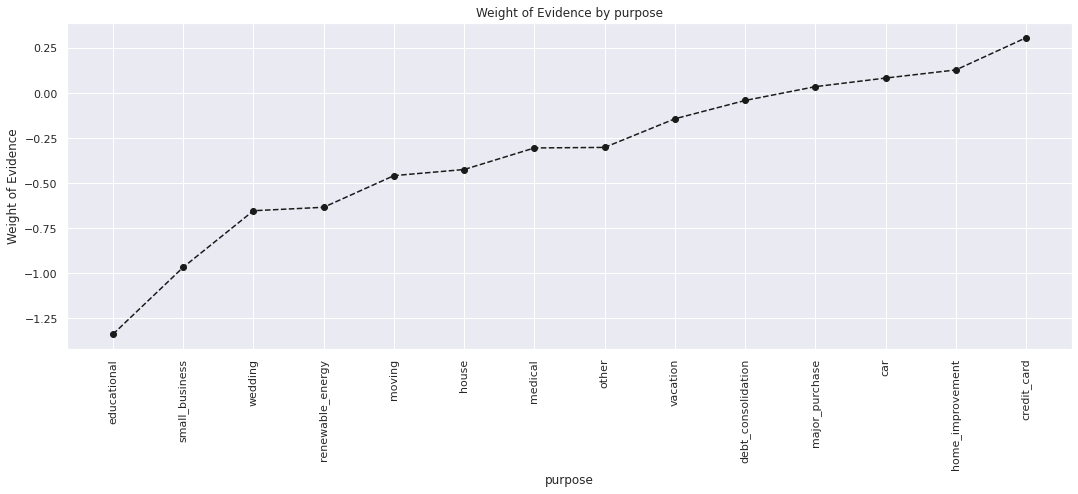

In [38]:
plot_by_woe(purpose_temp, 90)

In [39]:
# Binning into some categories base on Woe values and number of data
X_train_prepr['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([X_train_prepr['purpose:educational'], X_train_prepr['purpose:small_business'],
                                                                 X_train_prepr['purpose:wedding'], X_train_prepr['purpose:renewable_energy'],
                                                                 X_train_prepr['purpose:moving'], X_train_prepr['purpose:house']])
X_train_prepr['purpose:oth__med__vacation'] = sum([X_train_prepr['purpose:other'], X_train_prepr['purpose:medical'],
                                             X_train_prepr['purpose:vacation']])
X_train_prepr['purpose:major_purch__car__home_impr'] = sum([X_train_prepr['purpose:major_purchase'], X_train_prepr['purpose:car'],
                                                        X_train_prepr['purpose:home_improvement']])

##Analyze WoEs and IVs of numeric features

In [40]:
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

###**int_rate**

In [41]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['int_rate_factor'] = pd.cut(X_train_prepr['int_rate'], 50)
# Process 'int_rate_factor' column through woe_ordered_continuous and plot_by_woe functions
int_temp = woe_ordered_continuous(X_train_prepr, 'int_rate_factor', y_train_prepr)
int_temp

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.296, 5.793]",8445,0.996211,0.011896,8413.0,32.0,0.012692,0.000680,2.926569,NaN,NaN,0.559126
1,"(5.793, 6.267]",16685,0.988193,0.023503,16488.0,197.0,0.024874,0.004187,1.781956,0.008018,1.144613,0.559126
2,"(6.267, 6.74]",13036,0.980669,0.018363,12784.0,252.0,0.019286,0.005355,1.281292,0.007524,0.500664,0.559126
3,"(6.74, 7.214]",14577,0.989161,0.020534,14419.0,158.0,0.021753,0.003358,1.868478,0.008492,0.587186,0.559126
4,"(7.214, 7.687]",17552,0.979034,0.024725,17184.0,368.0,0.025924,0.007821,1.198422,0.010127,0.670056,0.559126
5,"(7.687, 8.16]",29452,0.977591,0.041487,28792.0,660.0,0.043437,0.014026,1.130384,0.001443,0.068038,0.559126
6,"(8.16, 8.634]",24922,0.986157,0.035106,24577.0,345.0,0.037078,0.007332,1.620793,0.008566,0.490409,0.559126
7,"(8.634, 9.107]",12391,0.947704,0.017454,11743.0,648.0,0.017716,0.013771,0.251893,0.038453,1.368900,0.559126
8,"(9.107, 9.581]",24241,0.985438,0.034147,23888.0,353.0,0.036038,0.007502,1.569435,0.037734,1.317542,0.559126
9,"(9.581, 10.054]",27108,0.972739,0.038185,26369.0,739.0,0.039781,0.015705,0.929418,0.012699,0.640017,0.559126


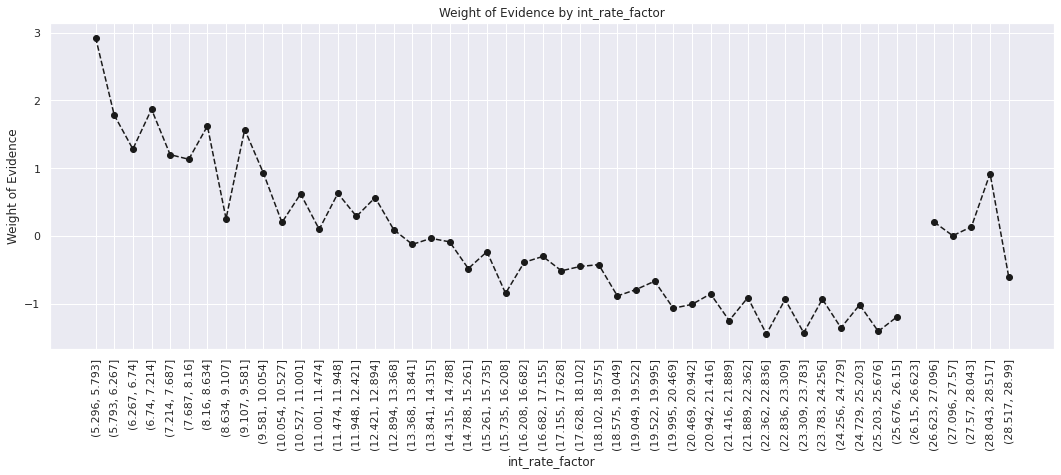

In [42]:
plot_by_woe(int_temp, 90)

In [43]:
#Discretize int_rate features
X_train_prepr['int_rate:<6.74'] = np.where((X_train_prepr['int_rate'] <= 6.74), 1, 0)
X_train_prepr['int_rate:6.74-8.16'] = np.where((X_train_prepr['int_rate'] > 6.74) & (X_train_prepr['int_rate'] <= 8.16), 1, 0)
X_train_prepr['int_rate:8.16-12.894'] = np.where((X_train_prepr['int_rate'] > 8.16) & (X_train_prepr['int_rate'] <= 12.894), 1, 0)
X_train_prepr['int_rate:12.894-16.208'] = np.where((X_train_prepr['int_rate'] > 12.894) & (X_train_prepr['int_rate'] <= 16.208), 1, 0)
X_train_prepr['int_rate:16.208-20.469'] = np.where((X_train_prepr['int_rate'] > 16.208) & (X_train_prepr['int_rate'] <= 20.469), 1, 0)
X_train_prepr['int_rate:>20.469'] = np.where((X_train_prepr['int_rate'] > 20.469), 1, 0)

###**annual_inc**

In [44]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['annual_inc_factor'] = pd.cut(X_train_prepr['annual_inc'], 50)
# Process 'annual_inc_factor' column through woe_ordered_continuous and plot_by_woe functions
ann_temp = woe_ordered_continuous(X_train_prepr, 'annual_inc_factor', y_train_prepr)
ann_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9500.0, 190000.0]",692689,0.933054,0.975757,646316.0,46373.0,0.975065,0.985506,-0.010651,NaN,NaN,inf
1,"(190000.0, 380000.0]",15195,0.958934,0.021404,14571.0,624.0,0.021983,0.013261,0.505416,0.025880,0.516067,inf
2,"(380000.0, 570000.0]",1384,0.971098,0.001950,1344.0,40.0,0.002028,0.000850,0.869304,0.012164,0.363888,inf
3,"(570000.0, 760000.0]",349,0.971347,0.000492,339.0,10.0,0.000511,0.000213,0.878192,0.000248,0.008889,inf
4,"(760000.0, 950000.0]",120,0.958333,0.000169,115.0,5.0,0.000173,0.000106,0.490272,0.013013,0.387921,inf
5,"(950000.0, 1140000.0]",69,1.000000,0.000097,69.0,0.0,0.000104,0.000000,inf,0.041667,inf,inf
6,"(1140000.0, 1330000.0]",26,0.923077,0.000037,24.0,2.0,0.000036,0.000043,-0.160316,0.076923,inf,inf
7,"(1330000.0, 1520000.0]",18,1.000000,0.000025,18.0,0.0,0.000027,0.000000,inf,0.076923,inf,inf
8,"(1520000.0, 1710000.0]",3,1.000000,0.000004,3.0,0.0,0.000005,0.000000,inf,0.000000,NaN,inf
9,"(1710000.0, 1900000.0]",7,1.000000,0.000010,7.0,0.0,0.000011,0.000000,inf,0.000000,NaN,inf


In [45]:
# Initial examination shows that there are too few individuals with large income (up to $75m!!) and too many with small income.
# Since 95.6% of observations have income < 151,858, we will have one category for more than 150K, and we are going to apply our approach to determine
# the categories of everyone with 150k or less.
X_train_prepr_temp = X_train_prepr.loc[X_train_prepr['annual_inc'] <= 150000, : ]
X_train_prepr_temp["annual_inc_factor"] = pd.cut(X_train_prepr_temp['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
ann_temp = woe_ordered_continuous(X_train_prepr_temp, 'annual_inc_factor', y_train_prepr)
# We calculate weight of evidence.
ann_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-150.0, 3000.0]",4,0.750000,0.000006,3.0,1.0,0.000005,0.000022,-1.526794,NaN,NaN,0.053156
1,"(3000.0, 6000.0]",44,0.886364,0.000065,39.0,5.0,0.000062,0.000110,-0.571283,0.136364,0.955511,0.053156
2,"(6000.0, 9000.0]",213,0.906103,0.000316,193.0,20.0,0.000307,0.000439,-0.358448,0.019740,0.212834,0.053156
3,"(9000.0, 12000.0]",1132,0.886042,0.001677,1003.0,129.0,0.001593,0.002830,-0.574468,0.020061,0.216020,0.053156
4,"(12000.0, 15000.0]",2097,0.902718,0.003106,1893.0,204.0,0.003007,0.004476,-0.397608,0.016676,0.176860,0.053156
5,"(15000.0, 18000.0]",2996,0.901869,0.004438,2702.0,294.0,0.004292,0.006450,-0.407239,0.000849,0.009630,0.053156
6,"(18000.0, 21000.0]",5534,0.909469,0.008198,5033.0,501.0,0.007995,0.010991,-0.318241,0.007600,0.088998,0.053156
7,"(21000.0, 24000.0]",7795,0.905067,0.011547,7055.0,740.0,0.011208,0.016235,-0.370565,0.004401,0.052324,0.053156
8,"(24000.0, 27000.0]",12170,0.907806,0.018028,11048.0,1122.0,0.017551,0.024616,-0.338270,0.002739,0.032295,0.053156
9,"(27000.0, 30000.0]",19419,0.909985,0.028766,17671.0,1748.0,0.028072,0.038349,-0.311954,0.002179,0.026316,0.053156


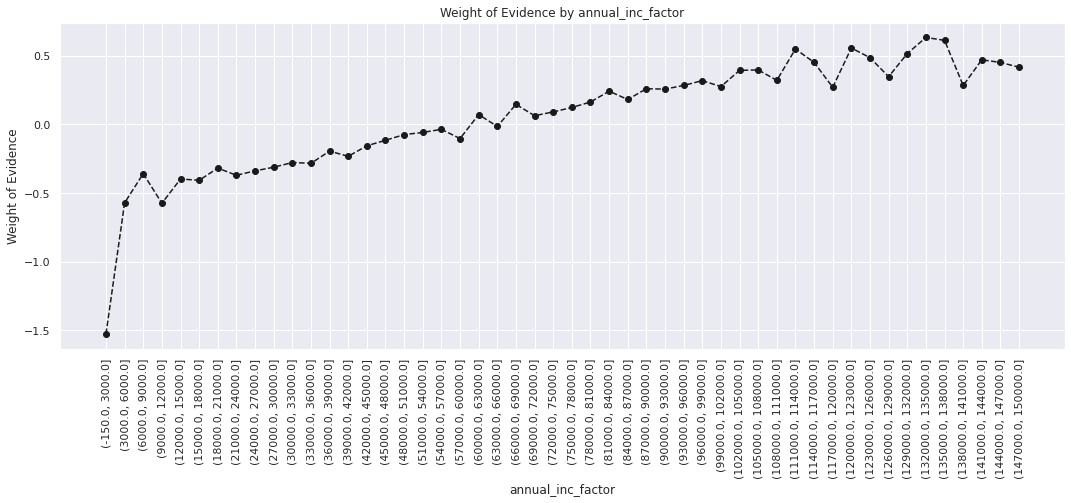

In [46]:
plot_by_woe(ann_temp, 90)

In [47]:
X_train_prepr['annual_inc:missing'] = np.where(X_train_prepr['annual_inc'].isnull(), 1, 0)
X_train_prepr['annual_inc:12.000'] = np.where((X_train_prepr['annual_inc'] <= 12000), 1, 0)
X_train_prepr['annual_inc:12.000-36.000'] = np.where((X_train_prepr['annual_inc'] > 20000) & (X_train_prepr['annual_inc'] <= 36000), 1, 0)
X_train_prepr['annual_inc:36.000-57.000'] = np.where((X_train_prepr['annual_inc'] > 36000) & (X_train_prepr['annual_inc'] <= 57000), 1, 0)
X_train_prepr['annual_inc:57.000-72.000'] = np.where((X_train_prepr['annual_inc'] > 57000) & (X_train_prepr['annual_inc'] <= 72000), 1, 0)
X_train_prepr['annual_inc:72.000-111.000'] = np.where((X_train_prepr['annual_inc'] > 72000) & (X_train_prepr['annual_inc'] <= 111000), 1, 0)
X_train_prepr['annual_inc:>111.000'] = np.where((X_train_prepr['annual_inc'] > 111000), 1, 0)

###**open_acc**

In [48]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['open_acc_factor'] = pd.cut(X_train_prepr['open_acc'], 50)
# Process 'open_acc_factor' column through woe_ordered_continuous and plot_by_woe functions
open_temp = woe_ordered_continuous(X_train_prepr, 'open_acc_factor', y_train_prepr)
open_temp

,open_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.09, 1.8]",193,0.911917,0.000272,176.0,17.0,0.000266,0.000361,-0.307990,NaN,NaN,inf
1,"(1.8, 3.6]",9943,0.912702,0.014007,9075.0,868.0,0.013691,0.018448,-0.298174,0.000785,0.009816,inf
2,"(3.6, 5.4]",50480,0.932231,0.071111,47059.0,3421.0,0.070997,0.072707,-0.023791,0.019528,0.274382,inf
3,"(5.4, 7.2]",98889,0.931357,0.139304,92101.0,6788.0,0.138952,0.144266,-0.037531,0.000873,0.013740,inf
4,"(7.2, 9.0]",125499,0.931601,0.176789,116915.0,8584.0,0.176388,0.182436,-0.033713,0.000244,0.003818,inf
5,"(9.0, 10.8]",62635,0.930949,0.088233,58310.0,4325.0,0.087972,0.091920,-0.043899,0.000652,0.010186,inf
6,"(10.8, 12.6]",109782,0.930499,0.154649,102152.0,7630.0,0.154116,0.162161,-0.050887,0.000451,0.006987,inf
7,"(12.6, 14.4]",83578,0.935162,0.117736,78159.0,5419.0,0.117918,0.115170,0.023573,0.004664,0.074460,inf
8,"(14.4, 16.2]",58555,0.936675,0.082486,54847.0,3708.0,0.082747,0.078806,0.048794,0.001513,0.025221,inf
9,"(16.2, 18.0]",39687,0.939149,0.055907,37272.0,2415.0,0.056232,0.051326,0.091282,0.002474,0.042488,inf


In [49]:
# We will groupping this data less than 30 
X_train_prepr_temp = X_train_prepr[X_train_prepr['open_acc'] <= 30].copy()
# fine-classing again
X_train_prepr_temp['open_acc_factor'] = pd.cut(X_train_prepr_temp['open_acc'], 50)
# make sure to select only the relevant indexes in the target column
open_temp = woe_ordered_continuous(X_train_prepr_temp, 'open_acc_factor', y_train_prepr)
open_temp

,open_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.03, 0.6]",7,0.428571,0.000010,3.0,4.0,0.000005,0.000085,-2.930807,NaN,NaN,0.007553
1,"(0.6, 1.2]",186,0.930108,0.000264,173.0,13.0,0.000263,0.000277,-0.054783,0.501536,2.876024,0.007553
2,"(1.2, 1.8]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007553
3,"(1.8, 2.4]",2215,0.890745,0.003139,1973.0,242.0,0.002995,0.005165,-0.544752,NaN,NaN,0.007553
4,"(2.4, 3.0]",7728,0.918996,0.010953,7102.0,626.0,0.010782,0.013360,-0.214344,0.028251,0.330409,0.007553
5,"(3.0, 3.6]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007553
6,"(3.6, 4.2]",18757,0.932079,0.026585,17483.0,1274.0,0.026542,0.027189,-0.024058,NaN,NaN,0.007553
7,"(4.2, 4.8]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007553
8,"(4.8, 5.4]",31723,0.932320,0.044962,29576.0,2147.0,0.044902,0.045819,-0.020233,NaN,NaN,0.007553
9,"(5.4, 6.0]",44698,0.931294,0.063353,41627.0,3071.0,0.063197,0.065538,-0.036379,0.001026,0.016146,0.007553


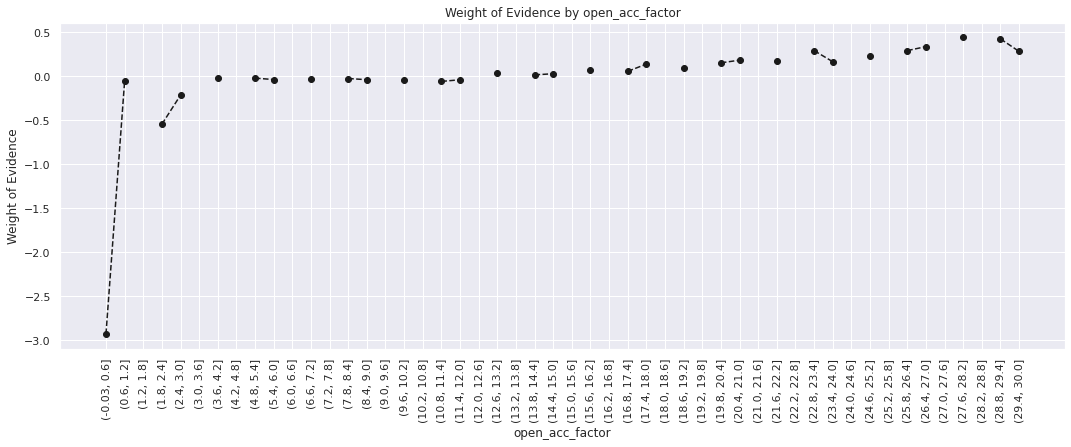

In [50]:
plot_by_woe(open_temp, 90)

Discarded this feature due to low IV score

###**pub_rec**

In [51]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['pub_rec_factor'] = pd.cut(X_train_prepr['pub_rec'], 50)
# Process 'pub_rec_factor' column through woe_ordered_continuous and plot_by_woe functions
pub_rec_temp = woe_ordered_continuous(X_train_prepr, 'pub_rec_factor', y_train_prepr)
pub_rec_temp

,pub_rec_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.086, 1.72]",691871,0.933181,0.974632,645641.0,46230.0,0.974072,0.982530,-0.008646,NaN,NaN,inf
1,"(1.72, 3.44]",15455,0.953284,0.021771,14733.0,722.0,0.022228,0.015345,0.370559,0.020103,0.379205,inf
2,"(3.44, 5.16]",1876,0.957356,0.002643,1796.0,80.0,0.002710,0.001700,0.466030,0.004072,0.095471,inf
3,"(5.16, 6.88]",311,0.961415,0.000438,299.0,12.0,0.000451,0.000255,0.570276,0.004059,0.104246,inf
4,"(6.88, 8.6]",224,0.982143,0.000316,220.0,4.0,0.000332,0.000085,1.362073,0.020728,0.791796,inf
5,"(8.6, 10.32]",69,0.971014,0.000097,67.0,2.0,0.000101,0.000043,0.866285,0.011128,0.495788,inf
6,"(10.32, 12.04]",33,0.939394,0.000046,31.0,2.0,0.000047,0.000043,0.095579,0.031621,0.770705,inf
7,"(12.04, 13.76]",10,1.000000,0.000014,10.0,0.0,0.000015,0.000000,inf,0.060606,inf,inf
8,"(13.76, 15.48]",7,1.000000,0.000010,7.0,0.0,0.000011,0.000000,inf,0.000000,NaN,inf
9,"(15.48, 17.2]",6,1.000000,0.000008,6.0,0.0,0.000009,0.000000,inf,0.000000,NaN,inf


In [52]:
X_train_prepr_temp = X_train_prepr[X_train_prepr['pub_rec'] <= 6].copy()
# fine-classing again
X_train_prepr_temp['pub_rec_factor'] = pd.cut(X_train_prepr_temp['pub_rec'], 50)
# make sure to select only the relevant indexes in the target column
pub_rec_temp = woe_ordered_continuous(X_train_prepr_temp, 'pub_rec_factor', y_train_prepr)
pub_rec_temp

,pub_rec_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.006, 0.12]",601284,0.932100,0.847460,560457.0,40827.0,0.846012,0.867847,-0.025482,NaN,NaN,0.005266
1,"(0.12, 0.24]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005266
2,"(0.24, 0.36]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005266
3,"(0.36, 0.48]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005266
4,"(0.48, 0.6]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005266
5,"(0.6, 0.72]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005266
6,"(0.72, 0.84]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005266
7,"(0.84, 0.96]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005266
8,"(0.96, 1.08]",90587,0.940356,0.127675,85184.0,5403.0,0.128586,0.114850,0.112969,NaN,NaN,0.005266
9,"(1.08, 1.2]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005266


Discarded this feature due to low IV score

###**revol_bal**

In [53]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['revol_bal_factor'] = pd.cut(X_train_prepr['revol_bal'], 50)
# Process 'revol_bal_factor' column through woe_ordered_continuous and plot_by_woe functions
revol_bal_temp = woe_ordered_continuous(X_train_prepr, 'revol_bal_factor', y_train_prepr)
revol_bal_temp

,revol_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-2904.836, 58096.72]",691967,0.933102,0.974735,645676.0,46291.0,0.974094,0.983764,-0.009878,NaN,NaN,inf
1,"(58096.72, 116193.44]",13278,0.956469,0.018704,12700.0,578.0,0.019160,0.012283,0.444555,0.023367,0.454433,inf
2,"(116193.44, 174290.16]",2705,0.957856,0.003810,2591.0,114.0,0.003909,0.002423,0.478372,0.001386,0.033817,inf
3,"(174290.16, 232386.88]",978,0.962168,0.001378,941.0,37.0,0.001420,0.000786,0.590797,0.004312,0.112424,inf
4,"(232386.88, 290483.6]",463,0.967603,0.000652,448.0,15.0,0.000676,0.000319,0.751514,0.005435,0.160718,inf
5,"(290483.6, 348580.32]",210,0.976190,0.000296,205.0,5.0,0.000309,0.000106,1.068343,0.008588,0.316829,inf
6,"(348580.32, 406677.04]",112,0.946429,0.000158,106.0,6.0,0.000160,0.000128,0.226451,0.029762,0.841892,inf
7,"(406677.04, 464773.76]",65,0.953846,0.000092,62.0,3.0,0.000094,0.000064,0.383294,0.007418,0.156842,inf
8,"(464773.76, 522870.48]",29,0.931034,0.000041,27.0,2.0,0.000041,0.000043,-0.042539,0.022812,0.425832,inf
9,"(522870.48, 580967.2]",31,1.000000,0.000044,31.0,0.0,0.000047,0.000000,inf,0.068966,inf,inf


In [54]:
X_train_prepr_temp = X_train_prepr[X_train_prepr['revol_bal'] <= 100000].copy()
# fine-classing again
X_train_prepr_temp['revol_bal_factor'] = pd.cut(X_train_prepr_temp['revol_bal'], 50)
# make sure to select only the relevant indexes in the target column
revol_bal_temp = woe_ordered_continuous(X_train_prepr_temp, 'revol_bal_factor', y_train_prepr)
revol_bal_temp

,revol_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-99.98, 1999.6]",34899,0.922147,0.049600,32182.0,2717.0,0.048998,0.058048,-0.169494,NaN,NaN,0.012237
1,"(1999.6, 3999.2]",55266,0.931947,0.078546,51505.0,3761.0,0.078418,0.080353,-0.024379,0.009801,0.145115,0.012237
2,"(3999.2, 5998.8]",71128,0.931855,0.101090,66281.0,4847.0,0.100915,0.103555,-0.025829,0.000092,0.001451,0.012237
3,"(5998.8, 7998.4]",71384,0.929424,0.101454,66346.0,5038.0,0.101014,0.107636,-0.063498,0.002431,0.037669,0.012237
4,"(7998.4, 9998.0]",66234,0.931289,0.094135,61683.0,4551.0,0.093914,0.097231,-0.034711,0.001865,0.028787,0.012237
5,"(9998.0, 11997.6]",59381,0.930045,0.084395,55227.0,4154.0,0.084085,0.088749,-0.053992,0.001244,0.019281,0.012237
6,"(11997.6, 13997.2]",50949,0.931186,0.072411,47443.0,3506.0,0.072233,0.074905,-0.036320,0.001141,0.017673,0.012237
7,"(13997.2, 15996.8]",43694,0.931295,0.062100,40692.0,3002.0,0.061955,0.064137,-0.034620,0.000109,0.001700,0.012237
8,"(15996.8, 17996.4]",36818,0.931990,0.052327,34314.0,2504.0,0.052244,0.053497,-0.023709,0.000695,0.010911,0.012237
9,"(17996.4, 19996.0]",30862,0.932733,0.043862,28786.0,2076.0,0.043827,0.044353,-0.011927,0.000743,0.011782,0.012237


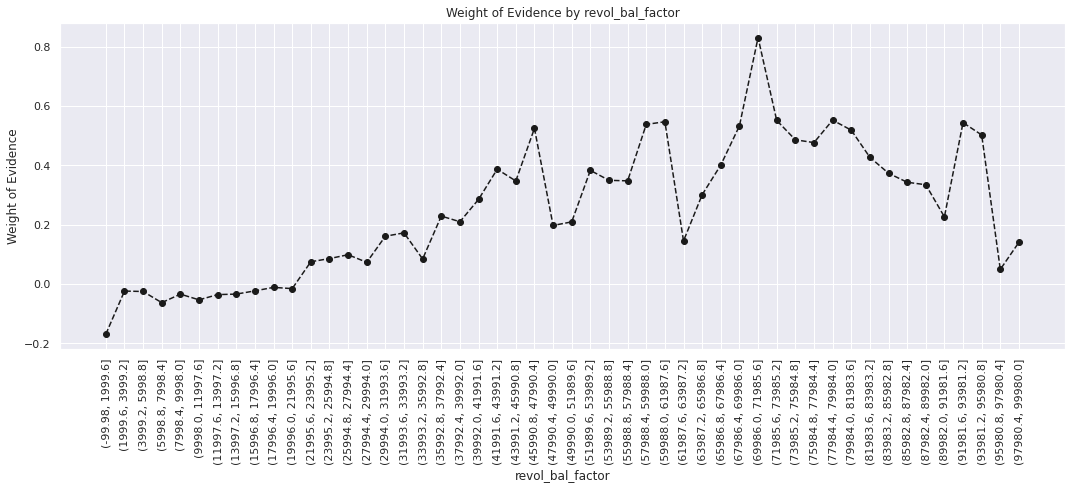

In [55]:
plot_by_woe(revol_bal_temp, 90)

We will not use this feature for the following reasons:
- very low IV
- WoE ranges between a very small range, implying low power of differentiating between good and bad loans

###**revol_util**

In [56]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['revol_util_factor'] = pd.cut(X_train_prepr['revol_util'], 50)
# Process 'revol_util_factor' column through woe_ordered_continuous and plot_by_woe functions
revol_util_temp = woe_ordered_continuous(X_train_prepr, 'revol_util_factor', y_train_prepr)
revol_util_temp

,revol_util_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.892, 17.846]",50567,0.949789,0.071271,48028.0,2539.0,0.072495,0.054013,0.294291,NaN,NaN,inf
1,"(17.846, 35.692]",109692,0.947963,0.154603,103984.0,5708.0,0.156957,0.121429,0.256646,0.001826,0.037646,inf
2,"(35.692, 53.538]",168950,0.940456,0.238123,158890.0,10060.0,0.239834,0.214011,0.113922,0.007508,0.142723,inf
3,"(53.538, 71.384]",182045,0.930764,0.256580,169441.0,12604.0,0.255760,0.268130,-0.047232,0.009691,0.161154,inf
4,"(71.384, 89.23]",143869,0.921470,0.202773,132571.0,11298.0,0.200107,0.240347,-0.183230,0.009294,0.135998,inf
5,"(89.23, 107.076]",54083,0.911728,0.076226,49309.0,4774.0,0.074429,0.101559,-0.310800,0.009742,0.127571,inf
6,"(107.076, 124.922]",244,0.938525,0.000344,229.0,15.0,0.000346,0.000319,0.079949,0.026796,0.390750,inf
7,"(124.922, 142.768]",43,0.813953,0.000061,35.0,8.0,0.000053,0.000170,-1.169816,0.124571,1.249765,inf
8,"(142.768, 160.614]",6,0.833333,0.000008,5.0,1.0,0.000008,0.000021,-1.036285,0.019380,0.133531,inf
9,"(160.614, 178.46]",3,1.000000,0.000004,3.0,0.0,0.000005,0.000000,inf,0.166667,inf,inf


In [57]:
X_train_prepr_temp = X_train_prepr[X_train_prepr['revol_util'] <= 100].copy()
# fine-classing again
X_train_prepr_temp['revol_util_factor'] = pd.cut(X_train_prepr_temp['revol_util'], 50)
# make sure to select only the relevant indexes in the target column
revol_util_temp = woe_ordered_continuous(X_train_prepr_temp, 'revol_util_factor', y_train_prepr)
revol_util_temp

,revol_util_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.1, 2.0]",6770,0.924963,0.009580,6262.0,508.0,0.009490,0.010856,-0.134514,NaN,NaN,0.039673
1,"(2.0, 4.0]",3641,0.948640,0.005152,3454.0,187.0,0.005234,0.003996,0.269892,0.023677,0.404406,0.039673
2,"(4.0, 6.0]",3976,0.954225,0.005626,3794.0,182.0,0.005749,0.003889,0.390882,0.005585,0.120990,0.039673
3,"(6.0, 8.0]",4483,0.952041,0.006344,4268.0,215.0,0.006468,0.004595,0.341975,0.002184,0.048907,0.039673
4,"(8.0, 10.0]",5327,0.952318,0.007538,5073.0,254.0,0.007688,0.005428,0.348066,0.000277,0.006091,0.039673
5,"(10.0, 12.0]",5759,0.957458,0.008149,5514.0,245.0,0.008356,0.005236,0.467500,0.005140,0.119434,0.039673
6,"(12.0, 14.0]",6292,0.951844,0.008904,5989.0,303.0,0.009076,0.006475,0.337659,0.005614,0.129840,0.039673
7,"(14.0, 16.0]",7188,0.954368,0.010172,6860.0,328.0,0.010396,0.007009,0.394161,0.002525,0.056502,0.039673
8,"(16.0, 18.0]",8044,0.955122,0.011383,7683.0,361.0,0.011643,0.007714,0.411600,0.000753,0.017438,0.039673
9,"(18.0, 20.0]",8806,0.952078,0.012461,8384.0,422.0,0.012705,0.009018,0.342787,0.003044,0.068812,0.039673


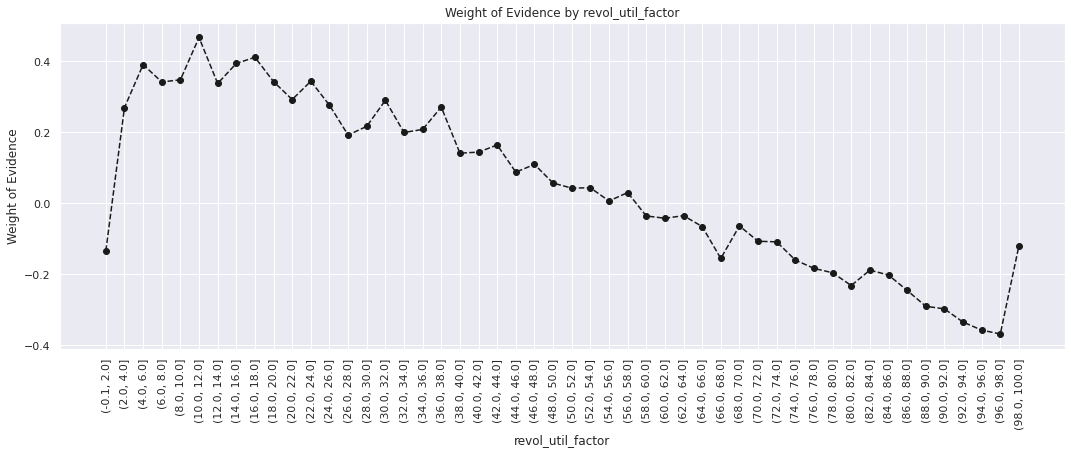

In [58]:
plot_by_woe(revol_util_temp,90)

In [59]:
X_train_prepr['revol_util:<=16'] = np.where((X_train_prepr['revol_util'] <= 16), 1, 0)
X_train_prepr['revol_util:16-32'] = np.where((X_train_prepr['revol_util'] > 16) & (X_train_prepr['revol_util'] <= 32), 1, 0)
X_train_prepr['revol_util:32-48'] = np.where((X_train_prepr['revol_util'] > 32) & (X_train_prepr['revol_util'] <= 48), 1, 0)
X_train_prepr['revol_util:48-62'] = np.where((X_train_prepr['revol_util'] > 48) & (X_train_prepr['revol_util'] <= 62), 1, 0)
X_train_prepr['revol_util:62-86'] = np.where((X_train_prepr['revol_util'] > 62) & (X_train_prepr['revol_util'] <= 86), 1, 0)
X_train_prepr['revol_util:>86'] = np.where((X_train_prepr['revol_util'] > 86), 1, 0)

###**total_acc**

In [60]:
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_acc'] <= 50].copy()
# fine-classing again
X_train_prepr_temp['total_acc_factor'] = pd.cut(X_train_prepr_temp['total_acc'], 50)
# make sure to select only the relevant indexes in the target column
total_acc_temp = woe_ordered_continuous(X_train_prepr_temp, 'total_acc_factor', y_train_prepr)
total_acc_temp

,total_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.951, 1.98]",17,0.823529,0.000025,14.0,3.0,0.000022,0.000066,-1.099670,NaN,NaN,0.009218
1,"(1.98, 2.96]",51,0.784314,0.000074,40.0,11.0,0.000062,0.000241,-1.349131,0.039216,0.249461,0.009218
2,"(2.96, 3.94]",377,0.795756,0.000549,300.0,77.0,0.000468,0.001685,-1.280138,0.011442,0.068993,0.009218
3,"(3.94, 4.92]",2310,0.910390,0.003366,2103.0,207.0,0.003283,0.004529,-0.321713,0.114634,0.958424,0.009218
4,"(4.92, 5.9]",3757,0.921214,0.005474,3461.0,296.0,0.005403,0.006476,-0.181161,0.010824,0.140552,0.009218
5,"(5.9, 6.88]",5435,0.920699,0.007919,5004.0,431.0,0.007812,0.009430,-0.188230,0.000515,0.007069,0.009218
6,"(6.88, 7.86]",7364,0.920695,0.010730,6780.0,584.0,0.010584,0.012777,-0.188283,0.000004,0.000053,0.009218
7,"(7.86, 8.84]",9620,0.923805,0.014018,8887.0,733.0,0.013873,0.016037,-0.144916,0.003109,0.043368,0.009218
8,"(8.84, 9.82]",11729,0.925228,0.017091,10852.0,877.0,0.016941,0.019187,-0.124517,0.001423,0.020399,0.009218
9,"(9.82, 10.8]",13926,0.926540,0.020292,12903.0,1023.0,0.020143,0.022382,-0.105394,0.001312,0.019123,0.009218


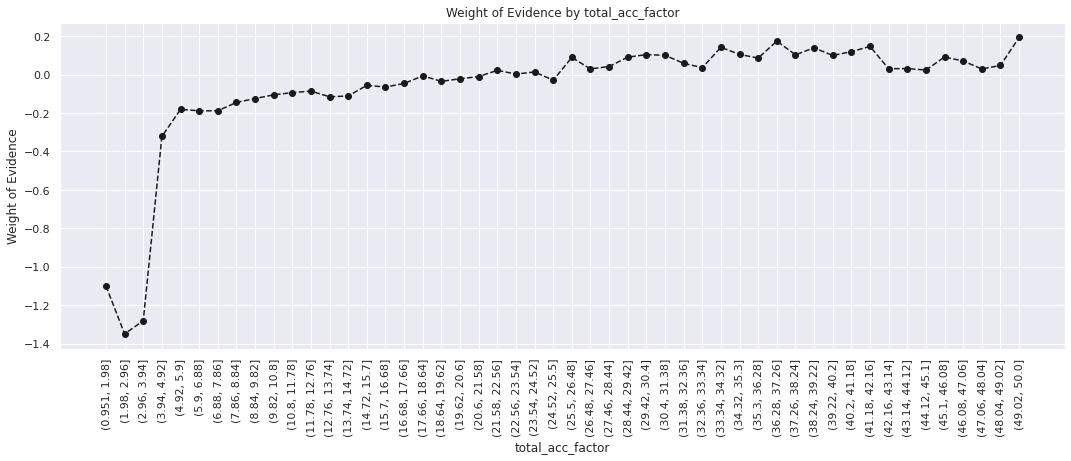

In [61]:
plot_by_woe(total_acc_temp,90)

We will not use this feature for the following reasons:
- very low IV
- WoE ranges between a very small range, implying low power of differentiating between good and bad loans

###**out_prncp**

In [62]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['out_prncp_factor'] = pd.cut(X_train_prepr['out_prncp'], 50)
# Process 'out_prncp_factor' column through woe_ordered_continuous and plot_by_woe functions
out_prncp_temp = woe_ordered_continuous(X_train_prepr, 'out_prncp_factor', y_train_prepr)
out_prncp_temp

,out_prncp_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-49.373, 987.457]",214502,0.827759,0.302157,177556.0,36946.0,0.267868,0.785166,-1.075400,NaN,NaN,inf
1,"(987.457, 1974.914]",18639,0.981061,0.026256,18286.0,353.0,0.027587,0.007502,1.302194,0.153302,2.377594,inf
2,"(1974.914, 2962.372]",23830,0.978808,0.033568,23325.0,505.0,0.035189,0.010732,1.187494,0.002253,0.114700,inf
3,"(2962.372, 3949.829]",26589,0.978675,0.037454,26022.0,567.0,0.039258,0.012050,1.181110,0.000133,0.006384,inf
4,"(3949.829, 4937.286]",30242,0.979598,0.042600,29625.0,617.0,0.044694,0.013112,1.226276,0.000923,0.045167,inf
5,"(4937.286, 5924.743]",27854,0.978100,0.039236,27244.0,610.0,0.041101,0.012964,1.153901,0.001498,0.072375,inf
6,"(5924.743, 6912.2]",25390,0.978614,0.035765,24847.0,543.0,0.037485,0.011540,1.178154,0.000514,0.024253,inf
7,"(6912.2, 7899.658]",25814,0.979352,0.036363,25281.0,533.0,0.038140,0.011327,1.214058,0.000739,0.035904,inf
8,"(7899.658, 8887.115]",25720,0.979627,0.036230,25196.0,524.0,0.038012,0.011136,1.227720,0.000274,0.013662,inf
9,"(8887.115, 9874.572]",29815,0.981016,0.041999,29249.0,566.0,0.044126,0.012028,1.299778,0.001390,0.072058,inf


In [63]:
X_train_prepr_temp = X_train_prepr[X_train_prepr['out_prncp'] <= 30000].copy()
# fine-classing again
X_train_prepr_temp['out_prncp_factor'] = pd.cut(X_train_prepr_temp['out_prncp'], 50)
# make sure to select only the relevant indexes in the target column
out_prncp_temp = woe_ordered_continuous(X_train_prepr_temp, 'out_prncp_factor', y_train_prepr)
out_prncp_temp

,out_prncp_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-30.0, 600.0]",208864,0.823502,0.300278,172000.0,36864.0,0.265104,0.788282,-1.089735,NaN,NaN,1.226591
1,"(600.0, 1200.0]",9000,0.984222,0.012939,8858.0,142.0,0.013653,0.003036,1.503255,0.160720,2.592990,1.226591
2,"(1200.0, 1800.0]",11239,0.981493,0.016158,11031.0,208.0,0.017002,0.004448,1.340933,0.002729,0.162323,1.226591
3,"(1800.0, 2400.0]",13547,0.980586,0.019476,13284.0,263.0,0.020475,0.005624,1.292167,0.000907,0.048765,1.226591
4,"(2400.0, 3000.0]",15322,0.977744,0.022028,14981.0,341.0,0.023090,0.007292,1.152661,0.002842,0.139506,1.226591
5,"(3000.0, 3600.0]",15777,0.978386,0.022682,15436.0,341.0,0.023792,0.007292,1.182581,0.000642,0.029920,1.226591
6,"(3600.0, 4200.0]",17010,0.978189,0.024455,16639.0,371.0,0.025646,0.007933,1.173308,0.000197,0.009273,1.226591
7,"(4200.0, 4800.0]",18650,0.979625,0.026813,18270.0,380.0,0.028160,0.008126,1.242850,0.001435,0.069542,1.226591
8,"(4800.0, 5400.0]",17172,0.978570,0.024688,16804.0,368.0,0.025900,0.007869,1.191295,0.001055,0.051555,1.226591
9,"(5400.0, 6000.0]",17155,0.979190,0.024663,16798.0,357.0,0.025891,0.007634,1.221285,0.000620,0.029990,1.226591


Discarded this feature due to anomaly IV score

###**total_pymnt**

In [64]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['total_pymnt_factor'] = pd.cut(X_train_prepr['total_pymnt'], 50)
# Process 'total_pymnt_factor' column through woe_ordered_continuous and plot_by_woe functions
total_pymnt_temp = woe_ordered_continuous(X_train_prepr, 'total_pymnt_factor', y_train_prepr)
total_pymnt_temp

,total_pymnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-57.778, 1155.552]",114311,0.959908,0.161023,109728.0,4583.0,0.165540,0.097397,0.530422,NaN,NaN,inf
1,"(1155.552, 2311.103]",92732,0.931038,0.130626,86337.0,6395.0,0.130252,0.135905,-0.042487,0.028870,0.572909,inf
2,"(2311.103, 3466.655]",75192,0.915829,0.105919,68863.0,6329.0,0.103890,0.134502,-0.258252,0.015209,0.215765,inf
3,"(3466.655, 4622.206]",60705,0.907998,0.085512,55120.0,5585.0,0.083156,0.118691,-0.355800,0.007831,0.097549,inf
4,"(4622.206, 5777.758]",50799,0.908660,0.071558,46159.0,4640.0,0.069637,0.098608,-0.347851,0.000662,0.007949,inf
5,"(5777.758, 6933.31]",42898,0.914914,0.060428,39248.0,3650.0,0.059211,0.077569,-0.270055,0.006255,0.077796,inf
6,"(6933.31, 8088.861]",35289,0.914534,0.049710,32273.0,3016.0,0.048688,0.064095,-0.274929,0.000380,0.004874,inf
7,"(8088.861, 9244.413]",29860,0.914869,0.042062,27318.0,2542.0,0.041213,0.054022,-0.270634,0.000335,0.004295,inf
8,"(9244.413, 10399.964]",25546,0.922571,0.035985,23568.0,1978.0,0.035556,0.042036,-0.167425,0.007702,0.103209,inf
9,"(10399.964, 11555.516]",25024,0.935822,0.035250,23418.0,1606.0,0.035329,0.034130,0.034530,0.013251,0.201955,inf


In [65]:
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_pymnt'] <= 30000].copy()
# fine-classing again
X_train_prepr_temp['total_pymnt_factor'] = pd.cut(X_train_prepr_temp['total_pymnt'], 50)
# make sure to select only the relevant indexes in the target column
total_pymnt_temp = woe_ordered_continuous(X_train_prepr_temp, 'total_pymnt_factor', y_train_prepr)
total_pymnt_temp

,total_pymnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-30.0, 600.0]",61027,0.969194,0.088056,59147.0,1880.0,0.091529,0.040139,0.824300,NaN,NaN,0.134936
1,"(600.0, 1200.0]",57083,0.947935,0.082365,54111.0,2972.0,0.083736,0.063454,0.277348,0.021259,0.546952,0.134936
2,"(1200.0, 1800.0]",49771,0.935826,0.071815,46577.0,3194.0,0.072077,0.068194,0.055379,0.012109,0.221970,0.134936
3,"(1800.0, 2400.0]",45655,0.924784,0.065876,42221.0,3434.0,0.065336,0.073318,-0.115262,0.011042,0.170641,0.134936
4,"(2400.0, 3000.0]",39558,0.913823,0.057078,36149.0,3409.0,0.055940,0.072784,-0.263224,0.010961,0.147962,0.134936
5,"(3000.0, 3600.0]",36557,0.914435,0.052748,33429.0,3128.0,0.051731,0.066785,-0.255424,0.000612,0.007800,0.134936
6,"(3600.0, 4200.0]",31983,0.909108,0.046148,29076.0,2907.0,0.044995,0.062066,-0.321663,0.005327,0.066238,0.134936
7,"(4200.0, 4800.0]",29473,0.907203,0.042527,26738.0,2735.0,0.041377,0.058394,-0.344500,0.001905,0.022837,0.134936
8,"(4800.0, 5400.0]",26333,0.905860,0.037996,23854.0,2479.0,0.036914,0.052928,-0.360357,0.001344,0.015858,0.134936
9,"(5400.0, 6000.0]",24760,0.913247,0.035726,22612.0,2148.0,0.034992,0.045861,-0.270511,0.007388,0.089847,0.134936


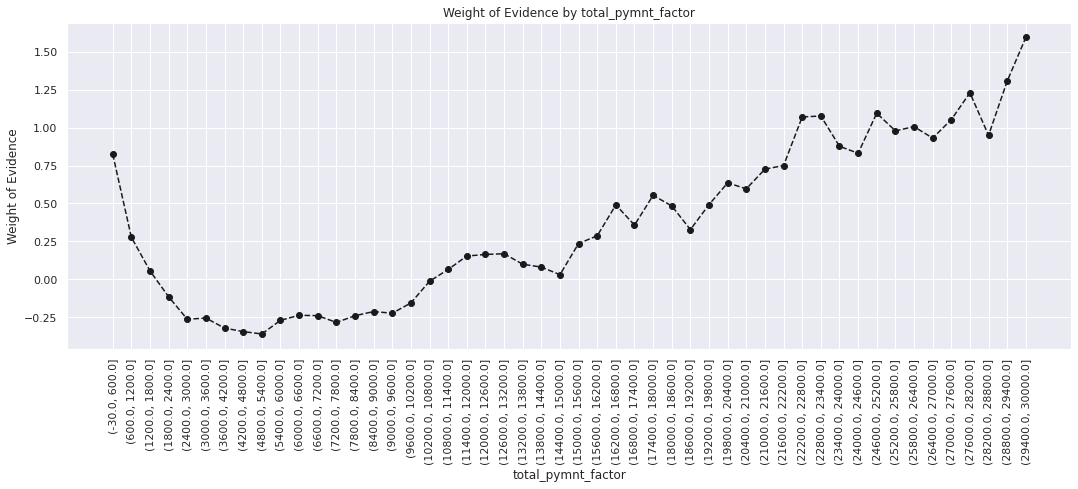

In [66]:
plot_by_woe(total_pymnt_temp,90)

In [67]:
X_train_prepr['total_pymnt:<=1800'] = np.where((X_train_prepr['total_pymnt'] <= 1800), 1, 0)
X_train_prepr['total_pymnt:1800-5400'] = np.where((X_train_prepr['total_pymnt'] > 1800) & (X_train_prepr['total_pymnt'] <= 5400), 1, 0)
X_train_prepr['total_pymnt:5400-9600'] = np.where((X_train_prepr['total_pymnt'] > 5400) & (X_train_prepr['total_pymnt'] <= 9600), 1, 0)
X_train_prepr['total_pymnt:9600-10800'] = np.where((X_train_prepr['total_pymnt'] > 9600) & (X_train_prepr['total_pymnt'] <= 10800), 1, 0)
X_train_prepr['total_pymnt:10800-15000'] = np.where((X_train_prepr['total_pymnt'] > 10800) & (X_train_prepr['total_pymnt'] <= 15000), 1, 0)
X_train_prepr['total_pymnt:15000-19800'] = np.where((X_train_prepr['total_pymnt'] > 15000) & (X_train_prepr['total_pymnt'] <= 19800), 1, 0)
X_train_prepr['total_pymnt:19800-22000'] = np.where((X_train_prepr['total_pymnt'] > 19800) & (X_train_prepr['total_pymnt'] <= 22000), 1, 0)
X_train_prepr['total_pymnt:>22000'] = np.where((X_train_prepr['total_pymnt'] > 22000), 1, 0)

###**total_rec_prncp**

In [68]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['total_rec_prncp_factor'] = pd.cut(X_train_prepr['total_rec_prncp'], 50)
# Process 'total_rec_prncp_factor' column through woe_ordered_continuous and plot_by_woe functions
total_rec_prncp_temp = woe_ordered_continuous(X_train_prepr, 'total_rec_prncp_factor', y_train_prepr)
total_rec_prncp_temp

,total_rec_prncp_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-35.0, 700.001]",109413,0.937439,0.154124,102568.0,6845.0,0.154738,0.145468,0.061779,NaN,NaN,0.383059
1,"(700.001, 1400.001]",89995,0.913373,0.126771,82199.0,7796.0,0.124009,0.165678,-0.289696,0.024066,0.351475,0.383059
2,"(1400.001, 2100.002]",71135,0.906460,0.100204,64481.0,6654.0,0.097279,0.141409,-0.374076,0.006913,0.084380,0.383059
3,"(2100.002, 2800.002]",55337,0.905597,0.077950,50113.0,5224.0,0.075603,0.111019,-0.384212,0.000863,0.010135,0.383059
4,"(2800.002, 3500.003]",46233,0.911189,0.065126,42127.0,4106.0,0.063555,0.087260,-0.316989,0.005592,0.067222,0.383059
5,"(3500.003, 4200.004]",36818,0.912977,0.051863,33614.0,3204.0,0.050711,0.068091,-0.294686,0.001788,0.022303,0.383059
6,"(4200.004, 4900.004]",28267,0.908374,0.039818,25677.0,2590.0,0.038737,0.055042,-0.351291,0.004604,0.056605,0.383059
7,"(4900.004, 5600.005]",29292,0.929639,0.041262,27231.0,2061.0,0.041082,0.043800,-0.064064,0.021266,0.287227,0.383059
8,"(5600.005, 6300.005]",24326,0.933816,0.034267,22716.0,1610.0,0.034270,0.034215,0.001607,0.004176,0.065671,0.383059
9,"(6300.005, 7000.006]",19957,0.933758,0.028112,18635.0,1322.0,0.028114,0.028095,0.000667,0.000058,0.000940,0.383059


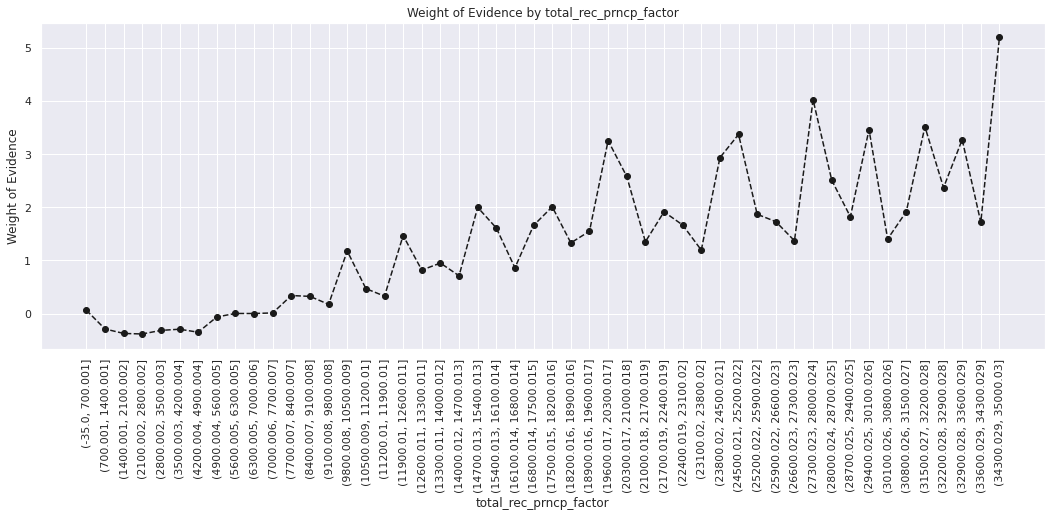

In [69]:
plot_by_woe(total_rec_prncp_temp,90)

In [70]:
X_train_prepr['total_rec_prncp:<=700'] = np.where((X_train_prepr['total_rec_prncp'] <= 700), 1, 0)
X_train_prepr['total_rec_prncp:700-4900'] = np.where((X_train_prepr['total_rec_prncp'] > 700) & (X_train_prepr['total_rec_prncp'] <= 4900), 1, 0)
X_train_prepr['total_rec_prncp:4900-7700'] = np.where((X_train_prepr['total_rec_prncp'] > 4900) & (X_train_prepr['total_rec_prncp'] <= 7700), 1, 0)
X_train_prepr['total_rec_prncp:>7700'] = np.where((X_train_prepr['total_rec_prncp'] > 7700), 1, 0)

###**total_rec_int**

In [71]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['total_rec_int_factor'] = pd.cut(X_train_prepr['total_rec_int'], 50)
# Process 'total_rec_int_factor' column through woe_ordered_continuous and plot_by_woe functions
total_rec_int_temp = woe_ordered_continuous(X_train_prepr, 'total_rec_int_factor', y_train_prepr)
total_rec_int_temp

,total_rec_int_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-24.206, 484.112]",191931,0.959668,0.270362,184190.0,7741.0,0.277877,0.164510,0.524208,NaN,NaN,inf
1,"(484.112, 968.225]",138522,0.938133,0.195128,129952.0,8570.0,0.196051,0.182127,0.073669,0.021535,0.450540,inf
2,"(968.225, 1452.337]",98203,0.929065,0.138333,91237.0,6966.0,0.137644,0.148040,-0.072809,0.009067,0.146478,inf
3,"(1452.337, 1936.45]",70107,0.924458,0.098756,64811.0,5296.0,0.097777,0.112549,-0.140705,0.004607,0.067896,inf
4,"(1936.45, 2420.562]",50778,0.920024,0.071528,46717.0,4061.0,0.070479,0.086303,-0.202550,0.004434,0.061845,inf
5,"(2420.562, 2904.674]",36360,0.917107,0.051218,33346.0,3014.0,0.050307,0.064053,-0.241559,0.002918,0.039009,inf
6,"(2904.674, 3388.787]",25926,0.913176,0.036520,23675.0,2251.0,0.035717,0.047838,-0.292183,0.003931,0.050625,inf
7,"(3388.787, 3872.899]",18913,0.912547,0.026642,17259.0,1654.0,0.026038,0.035150,-0.300091,0.000629,0.007908,inf
8,"(3872.899, 4357.012]",14592,0.907484,0.020555,13242.0,1350.0,0.019977,0.028690,-0.361940,0.005063,0.061848,inf
9,"(4357.012, 4841.124]",11560,0.907785,0.016284,10494.0,1066.0,0.015832,0.022654,-0.358338,0.000302,0.003601,inf


In [72]:
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_rec_int'] <= 10000].copy()
# fine-classing again
X_train_prepr_temp['total_rec_int_factor'] = pd.cut(X_train_prepr_temp['total_rec_int'], 50)
# make sure to select only the relevant indexes in the target column
total_rec_int_temp = woe_ordered_continuous(X_train_prepr_temp, 'total_rec_int_factor', y_train_prepr)
total_rec_int_temp

,total_rec_int_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-10.0, 199.996]",85339,0.968678,0.121559,82666.0,2673.0,0.126075,0.057677,0.782009,NaN,NaN,0.109044
1,"(199.996, 399.992]",77165,0.954733,0.109916,73672.0,3493.0,0.112358,0.075371,0.399264,0.013944,0.382745,0.109044
2,"(399.992, 599.989]",66471,0.943870,0.094683,62740.0,3731.0,0.095685,0.080507,0.172725,0.010863,0.226539,0.109044
3,"(599.989, 799.985]",58187,0.939660,0.082883,54676.0,3511.0,0.083387,0.075760,0.095926,0.004210,0.076799,0.109044
4,"(799.985, 999.981]",50964,0.933031,0.072595,47551.0,3413.0,0.072520,0.073645,-0.015387,0.006629,0.111313,0.109044
5,"(999.981, 1199.977]",43846,0.931716,0.062456,40852.0,2994.0,0.062304,0.064604,-0.036252,0.001316,0.020866,0.109044
6,"(1199.977, 1399.973]",37646,0.925703,0.053624,34849.0,2797.0,0.053149,0.060353,-0.127121,0.006013,0.090868,0.109044
7,"(1399.973, 1599.97]",33179,0.925977,0.047261,30723.0,2456.0,0.046856,0.052995,-0.123120,0.000275,0.004001,0.109044
8,"(1599.97, 1799.966]",28804,0.925601,0.041029,26661.0,2143.0,0.040661,0.046241,-0.128603,0.000377,0.005482,0.109044
9,"(1799.966, 1999.962]",25007,0.922422,0.035621,23067.0,1940.0,0.035180,0.041861,-0.173883,0.003179,0.045280,0.109044


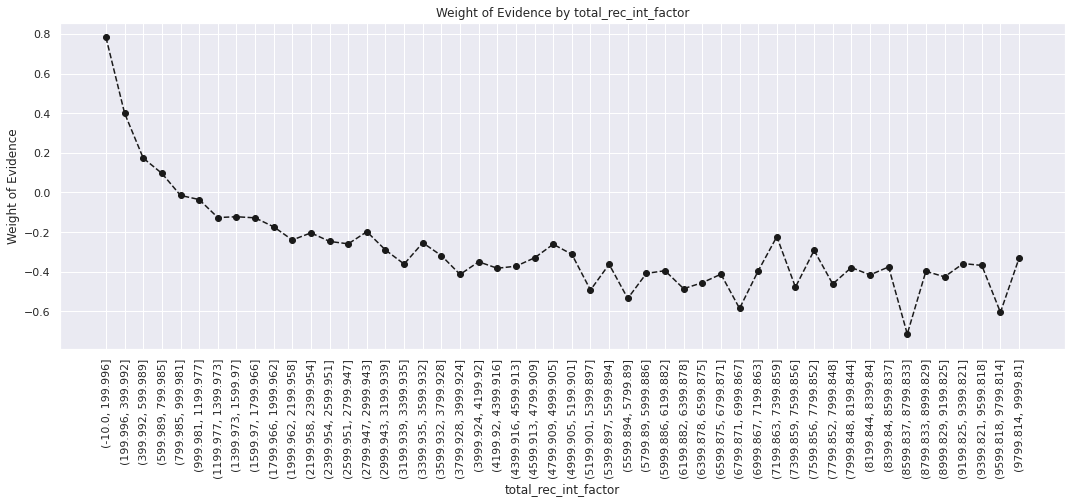

In [73]:
plot_by_woe(total_rec_int_temp,90)

In [74]:
X_train_prepr['total_rec_int:<=1200'] = np.where((X_train_prepr['total_rec_int'] <= 1200), 1, 0)
X_train_prepr['total_rec_int:1200-2000'] = np.where((X_train_prepr['total_rec_int'] > 1200) & (X_train_prepr['total_rec_int'] <= 2000), 1, 0)
X_train_prepr['total_rec_int:2000-3000'] = np.where((X_train_prepr['total_rec_int'] > 2000) & (X_train_prepr['total_rec_int'] <= 3000), 1, 0)
X_train_prepr['total_rec_int:3000-4000'] = np.where((X_train_prepr['total_rec_int'] > 3000) & (X_train_prepr['total_rec_int'] <= 4000), 1, 0)
X_train_prepr['total_rec_int:4000-5000'] = np.where((X_train_prepr['total_rec_int'] > 4000) & (X_train_prepr['total_rec_int'] <= 5000), 1, 0)
X_train_prepr['total_rec_int:>5000'] = np.where((X_train_prepr['total_rec_int'] > 5000), 1, 0)

###**total_rec_late_fee**

In [75]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['total_rec_late_fee_factor'] = pd.cut(X_train_prepr['total_rec_late_fee'], 50)
# Process 'total_rec_late_fee_factor' column through woe_ordered_continuous and plot_by_woe functions
total_rec_late_fee_temp = woe_ordered_continuous(X_train_prepr, 'total_rec_late_fee_factor', y_train_prepr)
total_rec_late_fee_temp

,total_rec_late_fee_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.295, 5.894]",700011,0.939084,0.986066,657369.0,42642.0,0.991734,0.906216,0.090177,NaN,NaN,inf
1,"(5.894, 11.787]",11,0.000000,0.000015,0.0,11.0,0.000000,0.000234,-inf,0.939084,inf,inf
2,"(11.787, 17.681]",4168,0.588772,0.005871,2454.0,1714.0,0.003702,0.036425,-2.286339,0.588772,inf,inf
3,"(17.681, 23.574]",1192,0.563758,0.001679,672.0,520.0,0.001014,0.011051,-2.388799,0.025013,0.102460,inf
4,"(23.574, 29.468]",1061,0.520264,0.001495,552.0,509.0,0.000833,0.010817,-2.564129,0.043494,0.175329,inf
5,"(29.468, 35.362]",1321,0.548827,0.001861,725.0,596.0,0.001094,0.012666,-2.449298,0.028563,0.114831,inf
6,"(35.362, 41.255]",515,0.504854,0.000725,260.0,255.0,0.000392,0.005419,-2.625810,0.043972,0.176513,inf
7,"(41.255, 47.149]",482,0.512448,0.000679,247.0,235.0,0.000373,0.004994,-2.595426,0.007594,0.030385,inf
8,"(47.149, 53.042]",299,0.494983,0.000421,148.0,151.0,0.000223,0.003209,-2.665296,0.017465,0.069870,inf
9,"(53.042, 58.936]",162,0.537037,0.000228,87.0,75.0,0.000131,0.001594,-2.496809,0.042054,0.168488,inf


In [76]:
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_rec_late_fee'] <= 0.1].copy()
# fine-classing again
X_train_prepr_temp['total_rec_late_fee_factor'] = pd.cut(X_train_prepr_temp['total_rec_late_fee'], 50)
# make sure to select only the relevant indexes in the target column
total_rec_late_fee_temp = woe_ordered_continuous(X_train_prepr_temp, 'total_rec_late_fee_factor', y_train_prepr)
total_rec_late_fee_temp

,total_rec_late_fee_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-7.38e-05, 0.00148]",699976,0.939115,0.999989,657358.0,42618.0,0.999997,0.999859,0.000138,NaN,NaN,inf
1,"(0.00148, 0.00295]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
2,"(0.00295, 0.00443]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,"(0.00443, 0.0059]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
4,"(0.0059, 0.00738]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
5,"(0.00738, 0.00885]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
6,"(0.00885, 0.0103]",6,0.000000,0.000009,0.0,6.0,0.000000,0.000141,-inf,NaN,NaN,inf
7,"(0.0103, 0.0118]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
8,"(0.0118, 0.0133]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(0.0133, 0.0148]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


Ignore this feature due to too much small values that have a small range

###**recoveries**

In [77]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['recoveries_factor'] = pd.cut(X_train_prepr['recoveries'], 50)
# Process 'recoveries_factor' column through woe_ordered_continuous and plot_by_woe functions
recoveries_temp = woe_ordered_continuous(X_train_prepr, 'recoveries_factor', y_train_prepr)
recoveries_temp

,recoveries_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-33.52, 670.405]",696834,0.951228,0.981590,662848.0,33986.0,1.0,0.722261,0.325368,NaN,NaN,inf
1,"(670.405, 1340.811]",4299,0.000000,0.006056,0.0,4299.0,0.0,0.091361,-inf,0.951228,inf,inf
2,"(1340.811, 2011.216]",2808,0.000000,0.003955,0.0,2808.0,0.0,0.059675,-inf,0.000000,NaN,inf
3,"(2011.216, 2681.622]",2030,0.000000,0.002860,0.0,2030.0,0.0,0.043141,-inf,0.000000,NaN,inf
4,"(2681.622, 3352.027]",1392,0.000000,0.001961,0.0,1392.0,0.0,0.029582,-inf,0.000000,NaN,inf
5,"(3352.027, 4022.432]",912,0.000000,0.001285,0.0,912.0,0.0,0.019382,-inf,0.000000,NaN,inf
6,"(4022.432, 4692.838]",593,0.000000,0.000835,0.0,593.0,0.0,0.012602,-inf,0.000000,NaN,inf
7,"(4692.838, 5363.243]",396,0.000000,0.000558,0.0,396.0,0.0,0.008416,-inf,0.000000,NaN,inf
8,"(5363.243, 6033.649]",211,0.000000,0.000297,0.0,211.0,0.0,0.004484,-inf,0.000000,NaN,inf
9,"(6033.649, 6704.054]",118,0.000000,0.000166,0.0,118.0,0.0,0.002508,-inf,0.000000,NaN,inf


In [78]:
X_train_prepr_temp = X_train_prepr[X_train_prepr['recoveries'] <= 0.005].copy()
# fine-classing again
X_train_prepr_temp['recoveries_factor'] = pd.cut(X_train_prepr_temp['recoveries'], 50)
# make sure to select only the relevant indexes in the target column
recoveries_temp = woe_ordered_continuous(X_train_prepr_temp, 'recoveries_factor', y_train_prepr)
recoveries_temp

,recoveries_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.001, -0.00096]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,"(-0.00096, -0.00092]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,"(-0.00092, -0.00088]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,"(-0.00088, -0.00084]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,"(-0.00084, -0.0008]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,"(-0.0008, -0.00076]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,"(-0.00076, -0.00072]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,"(-0.00072, -0.00068]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,"(-0.00068, -0.00064]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,"(-0.00064, -0.0006]",0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Ignore this feature due to too much small values that have a small range

###**tot_cur_bal**

In [79]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['tot_cur_bal_factor'] = pd.cut(X_train_prepr['tot_cur_bal'], 50)
# Process 'tot_cur_bal_factor' column through woe_ordered_continuous and plot_by_woe functions
tot_cur_bal_temp = woe_ordered_continuous(X_train_prepr, 'tot_cur_bal_factor', y_train_prepr)
tot_cur_bal_temp

,tot_cur_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-8000.078, 160001.56]",430697,0.935544,0.658949,402936.0,27761.0,0.654892,0.724055,-0.100397,NaN,NaN,inf
1,"(160001.56, 320003.12]",150135,0.948366,0.229700,142383.0,7752.0,0.231415,0.202186,0.135027,0.012822,0.235424,inf
2,"(320003.12, 480004.68]",51303,0.958190,0.078492,49158.0,2145.0,0.079897,0.055945,0.356357,0.009823,0.221330,inf
3,"(480004.68, 640006.24]",14063,0.967077,0.021516,13600.0,463.0,0.022104,0.012076,0.604555,0.008887,0.248198,inf
4,"(640006.24, 800007.8]",4354,0.970142,0.006661,4224.0,130.0,0.006865,0.003391,0.705460,0.003066,0.100905,inf
5,"(800007.8, 960009.36]",1505,0.968106,0.002303,1457.0,48.0,0.002368,0.001252,0.637391,0.002036,0.068070,inf
6,"(960009.36, 1120010.92]",685,0.967883,0.001048,663.0,22.0,0.001078,0.000574,0.630190,0.000223,0.007201,inf
7,"(1120010.92, 1280012.48]",350,0.980000,0.000535,343.0,7.0,0.000557,0.000183,1.116277,0.012117,0.486088,inf
8,"(1280012.48, 1440014.04]",187,0.983957,0.000286,184.0,3.0,0.000299,0.000078,1.340780,0.003957,0.224503,inf
9,"(1440014.04, 1600015.6]",103,0.980583,0.000158,101.0,2.0,0.000164,0.000052,1.146430,0.003375,0.194350,inf


In [80]:
X_train_prepr_temp = X_train_prepr[X_train_prepr['tot_cur_bal'] <= 50000].copy()
# fine-classing again
X_train_prepr_temp['tot_cur_bal_factor'] = pd.cut(X_train_prepr_temp['tot_cur_bal'], 50)
# make sure to select only the relevant indexes in the target column
tot_cur_bal_temp = woe_ordered_continuous(X_train_prepr_temp, 'tot_cur_bal_factor', y_train_prepr)
tot_cur_bal_temp

,tot_cur_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-50.0, 1000.0]",1045,0.928230,0.004065,970.0,75.0,0.004046,0.004327,-0.067238,NaN,NaN,0.003768
1,"(1000.0, 2000.0]",1405,0.937367,0.005465,1317.0,88.0,0.005493,0.005077,0.078729,0.009137,0.145967,0.003768
2,"(2000.0, 3000.0]",2061,0.941291,0.008017,1940.0,121.0,0.008092,0.006981,0.147606,0.003924,0.068878,0.003768
3,"(3000.0, 4000.0]",3298,0.934809,0.012829,3083.0,215.0,0.012859,0.012405,0.035974,0.006482,0.111632,0.003768
4,"(4000.0, 5000.0]",4028,0.938183,0.015668,3779.0,249.0,0.015762,0.014366,0.092715,0.003374,0.056741,0.003768
5,"(5000.0, 6000.0]",4465,0.941545,0.017368,4204.0,261.0,0.017535,0.015059,0.152225,0.003363,0.059510,0.003768
6,"(6000.0, 7000.0]",4872,0.938834,0.018951,4574.0,298.0,0.019078,0.017194,0.104004,0.002711,0.048221,0.003768
7,"(7000.0, 8000.0]",5188,0.935235,0.020180,4852.0,336.0,0.020238,0.019386,0.042989,0.003599,0.061015,0.003768
8,"(8000.0, 9000.0]",5435,0.932291,0.021141,5067.0,368.0,0.021134,0.021232,-0.004625,0.002944,0.047614,0.003768
9,"(9000.0, 10000.0]",5741,0.928932,0.022331,5333.0,408.0,0.022244,0.023540,-0.056644,0.003358,0.052019,0.003768


Dicarded this features due to lower IV scores

## Define Custom Class for WoE Binning/Reengineering

In [81]:
# create a list of all the reference categories, i.e. one category from each of the global features
ref_categories = ['term:36',
'int_rate:<6.74',
'grade:G',
'home_ownership:OWN',
'annual_inc:<=12.000',
'verification_status:Not Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'revol_util:<=16',
'total_pymnt:<=1800',
'total_rec_prncp:<=700',
'total_rec_int:<=1200']

In [82]:
# This custom class will create new categorical dummy features based on the cut-off points that we manually identified
# based on the WoE plots and IV above.
# Given the way it is structured, this class also allows a fit_transform method to be implemented on it, thereby allowing 
# us to use it as part of a scikit-learn Pipeline 
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:, 'grade:A': 'grade:G']
        X_new['term:36'] = np.where((X['term'] == 36), 1, 0)
        X_new['term:60'] = np.where((X['term'] == 60), 1, 0)
        X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
        X_new['home_ownership:RENT_OTHER'] = sum([X['home_ownership:RENT'], X['home_ownership:OTHER']])
        X_new = pd.concat([X_new, X.loc[:, 'verification_status:Not Verified':'verification_status:Verified']], axis = 1)
        X_new['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([X['purpose:educational'], X['purpose:small_business'], X['purpose:wedding'], 
                                                                     X['purpose:renewable_energy'], X['purpose:moving'], X['purpose:house']])
        X_new['purpose:oth__med__vacation'] = sum([X['purpose:other'], X['purpose:medical'], X['purpose:vacation']])
        X_new['purpose:major_purch__car__home_impr'] = sum([X['purpose:major_purchase'], X['purpose:car'], X['purpose:home_improvement']])
        X_new['int_rate:missing'] = np.where(X['int_rate'].isnull(), 1, 0)
        X_new['int_rate:<6.74'] = np.where((X['int_rate'] <= 6.74), 1, 0)
        X_new['int_rate:6.74-8.16'] = np.where((X['int_rate'] > 6.74) & (X['int_rate'] <= 8.16), 1, 0)
        X_new['int_rate:8.16-12.894'] = np.where((X['int_rate'] > 8.16) & (X['int_rate'] <= 12.894), 1, 0)
        X_new['int_rate:12.894-16.208'] = np.where((X['int_rate'] > 12.894) & (X['int_rate'] <= 16.208), 1, 0)
        X_new['int_rate:16.208-20.469'] = np.where((X['int_rate'] > 16.208) & (X['int_rate'] <= 20.469), 1, 0)
        X_new['int_rate:>20.469'] = np.where((X['int_rate'] > 20.469), 1, 0)
        X_new['annual_inc:missing'] = np.where(X['annual_inc'].isnull(), 1, 0)
        X_new['annual_inc:<=12.000'] = np.where((X['annual_inc'] <= 12000), 1, 0)
        X_new['annual_inc:12.000-36.000'] = np.where((X['annual_inc'] > 20000) & (X['annual_inc'] <= 36000), 1, 0)
        X_new['annual_inc:36.000-57.000'] = np.where((X['annual_inc'] > 36000) & (X['annual_inc'] <= 57000), 1, 0)
        X_new['annual_inc:57.000-72.000'] = np.where((X['annual_inc'] > 57000) & (X['annual_inc'] <= 72000), 1, 0)
        X_new['annual_inc:72.000-111.000'] = np.where((X['annual_inc'] > 72000) & (X['annual_inc'] <= 111000), 1, 0)
        X_new['annual_inc:>111.000'] = np.where((X['annual_inc'] > 111000), 1, 0)
        X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
        X_new['revol_util:<=16'] = np.where((X['revol_util'] <= 16), 1, 0)
        X_new['revol_util:16-32'] = np.where((X['revol_util'] > 16) & (X['revol_util'] <= 32), 1, 0)
        X_new['revol_util:32-48'] = np.where((X['revol_util'] > 32) & (X['revol_util'] <= 48), 1, 0)
        X_new['revol_util:48-62'] = np.where((X['revol_util'] > 48) & (X['revol_util'] <= 62), 1, 0)
        X_new['revol_util:62-86'] = np.where((X['revol_util'] > 62) & (X['revol_util'] <= 86), 1, 0)
        X_new['revol_util:>86'] = np.where((X['revol_util'] > 86), 1, 0)
        X_new['total_pymnt:<=1800'] = np.where((X['total_pymnt'] <= 1800), 1, 0)
        X_new['total_pymnt:1800-5400'] = np.where((X['total_pymnt'] > 1800) & (X['total_pymnt'] <= 5400), 1, 0)
        X_new['total_pymnt:5400-9600'] = np.where((X['total_pymnt'] > 5400) & (X['total_pymnt'] <= 9600), 1, 0)
        X_new['total_pymnt:9600-10800'] = np.where((X['total_pymnt'] > 9600) & (X['total_pymnt'] <= 10800), 1, 0)
        X_new['total_pymnt:10800-15000'] = np.where((X['total_pymnt'] > 10800) & (X['total_pymnt'] <= 15000), 1, 0)
        X_new['total_pymnt:15000-19800'] = np.where((X['total_pymnt'] > 15000) & (X['total_pymnt'] <= 19800), 1, 0)
        X_new['total_pymnt:19800-22000'] = np.where((X['total_pymnt'] > 19800) & (X['total_pymnt'] <= 22000), 1, 0)
        X_new['total_pymnt:>22000'] = np.where((X['total_pymnt'] > 22000), 1, 0)
        X_new['total_rec_prncp:<=700'] = np.where((X['total_rec_prncp'] <= 700), 1, 0)
        X_new['total_rec_prncp:700-4900'] = np.where((X['total_rec_prncp'] > 700) & (X['total_rec_prncp'] <= 4900), 1, 0)
        X_new['total_rec_prncp:4900-7700'] = np.where((X['total_rec_prncp'] > 4900) & (X['total_rec_prncp'] <= 7700), 1, 0)
        X_new['total_rec_prncp:>7700'] = np.where((X['total_rec_prncp'] > 7700), 1, 0)
        X_new['total_rec_int:<=1200'] = np.where((X['total_rec_int'] <= 1200), 1, 0)
        X_new['total_rec_int:1200-2000'] = np.where((X['total_rec_int'] > 1200) & (X['total_rec_int'] <= 2000), 1, 0)
        X_new['total_rec_int:2000-3000'] = np.where((X['total_rec_int'] > 2000) & (X['total_rec_int'] <= 3000), 1, 0)
        X_new['total_rec_int:3000-4000'] = np.where((X['total_rec_int'] > 3000) & (X['total_rec_int'] <= 4000), 1, 0)
        X_new['total_rec_int:4000-5000'] = np.where((X['total_rec_int'] > 4000) & (X['total_rec_int'] <= 5000), 1, 0)
        X_new['total_rec_int:>5000'] = np.where((X['total_rec_int'] > 5000), 1, 0)
        X_new.drop(columns = ref_categories, inplace = True)
        return X_new
# we could have also structured this class without the last drop statement and without creating categories out of the 
# feature categories. But doing the way we have done here allows us to keep a proper track of the categories, if required

#Probality of Defaults MODEL

In [83]:
# reconfirm shape of the 4 datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(709903, 48)
(709903,)
(177476, 48)
(177476,)


In [84]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7631
Gini: 0.5262


In [85]:
# pretty impressive scores for the first time, now let's fit the pipeline on the whole training set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe',
                 WoE_Binning(X=        loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0          5000.0       5000.0           4975.0    36     10.65       162.87   
1          2500.0       2500.0           2500.0    60     15.27        59.83   
2          2400.0       2400.0           2400.0    36     15.96        84.33   
3         10000.0      10000.0          10000.0    36     13.49       339.31   
4          3000.0       3000.0           3000.0    60     12.69        67.79   
...           ...          ...              ...   ...       ...          ...   
887374    10000.0      10000.0          10000.0    36     11.99       332.10   
887375    24000.0      24000.0          24000.0    36     11.9...
        acc_now_delinq  tot_coll_amt  tot_cur_bal  total_rev_hi_lim  
0                  0.0           NaN          NaN               NaN  
1                  0.0           NaN          NaN               NaN  
2                  0.0       

In [86]:
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature_name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature_name,Coefficients
0,Intercept,2.179676
1,grade:A,-1.099134
2,grade:B,-0.641620
3,grade:C,0.043518
4,grade:D,0.258806
5,grade:E,0.378732
6,grade:F,0.262594
7,term:60,0.720396
8,home_ownership:MORTGAGE,-0.058438
9,home_ownership:RENT_OTHER,-0.210581


# Prediction Time!

In [87]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

In [88]:
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(177476, 2)

In [89]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
159559,1,0.623438
281057,1,0.325708
346631,1,0.631015
151745,1,0.682102
214714,0,0.436717


## Confusion Matrix and AUROC on Test Set

In [90]:
# assign a threshold value to differentiate good with bad
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimat threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.04722329, 0.01906173],
       [0.29828258, 0.6354324 ]])

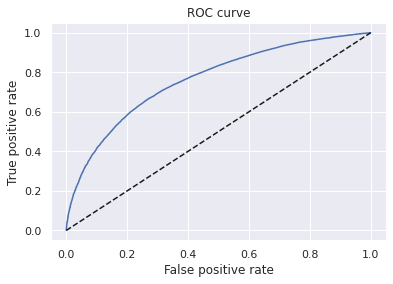

In [91]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [92]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.7622966498482088

In [93]:
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
Gini

0.5245932996964175

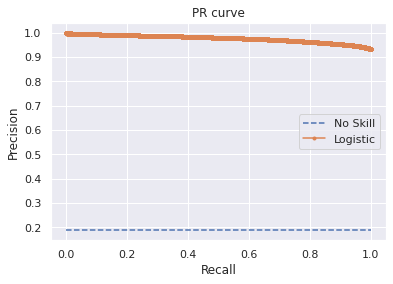

In [94]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [95]:
# calculate PR AUC
auc_pr = auc(recall, precision)
auc_pr

0.9761313681340151

# Applying the Model - Scorecard Creation

In [96]:
summary_table

,Feature_name,Coefficients
0,Intercept,2.179676
1,grade:A,-1.099134
2,grade:B,-0.641620
3,grade:C,0.043518
4,grade:D,0.258806
5,grade:E,0.378732
6,grade:F,0.262594
7,term:60,0.720396
8,home_ownership:MORTGAGE,-0.058438
9,home_ownership:RENT_OTHER,-0.210581


In [97]:
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list. We name it 'Feature name'.
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature_name'])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0
df_ref_categories

,Feature_name,Coefficients
0,term:36,0
1,int_rate:<6.74,0
2,grade:G,0
3,home_ownership:OWN,0
4,annual_inc:<=12.000,0
5,verification_status:Not Verified,0
6,purpose:educ__sm_b__wedd__ren_en__mov__house,0
7,revol_util:<=16,0
8,total_pymnt:<=1800,0
9,total_rec_prncp:<=700,0


In [98]:
# Concatenates two dataframes.
df_scorecard = pd.concat([summary_table, df_ref_categories])
# We reset the index of a dataframe.
df_scorecard.reset_index(inplace = True)
df_scorecard

,index,Feature_name,Coefficients
0,0,Intercept,2.179676
1,1,grade:A,-1.099134
2,2,grade:B,-0.641620
3,3,grade:C,0.043518
4,4,grade:D,0.258806
5,5,grade:E,0.378732
6,6,grade:F,0.262594
7,7,term:60,0.720396
8,8,home_ownership:MORTGAGE,-0.058438
9,9,home_ownership:RENT_OTHER,-0.210581


In [99]:
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column, up to the column symbol.
df_scorecard['Original feature name'] = df_scorecard['Feature_name'].str.split(':').str[0]
df_scorecard

,index,Feature_name,Coefficients,Original feature name
0,0,Intercept,2.179676,Intercept
1,1,grade:A,-1.099134,grade
2,2,grade:B,-0.641620,grade
3,3,grade:C,0.043518,grade
4,4,grade:D,0.258806,grade
5,5,grade:E,0.378732,grade
6,6,grade:F,0.262594,grade
7,7,term:60,0.720396,term
8,8,home_ownership:MORTGAGE,-0.058438,home_ownership
9,9,home_ownership:RENT_OTHER,-0.210581,home_ownership


In [100]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [101]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,index,Feature_name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,2.179676,Intercept,644.542963,645.0
1,1,grade:A,-1.099134,grade,-44.099350,-44.0
2,2,grade:B,-0.641620,grade,-25.743012,-26.0
3,3,grade:C,0.043518,grade,1.746020,2.0
4,4,grade:D,0.258806,grade,10.383783,10.0
5,5,grade:E,0.378732,grade,15.195471,15.0
6,6,grade:F,0.262594,grade,10.535772,11.0
7,7,term:60,0.720396,term,28.903679,29.0
8,8,home_ownership:MORTGAGE,-0.058438,home_ownership,-2.344642,-2.0
9,9,home_ownership:RENT_OTHER,-0.210581,home_ownership,-8.448897,-8.0


In [102]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

301.0
850.0


In [103]:
# so both our min and max scores are out by +1. we need to manually adjust this
# Which one? We'll evaluate based on the rounding differences of the minimum category within each Original Feature Name.
pd.options.display.max_rows = None
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard.reindex()

,index,Feature_name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,2.179676,Intercept,644.542963,645.0,0.457037
1,1,grade:A,-1.099134,grade,-44.099350,-44.0,0.099350
2,2,grade:B,-0.641620,grade,-25.743012,-26.0,-0.256988
3,3,grade:C,0.043518,grade,1.746020,2.0,0.253980
4,4,grade:D,0.258806,grade,10.383783,10.0,-0.383783
5,5,grade:E,0.378732,grade,15.195471,15.0,-0.195471
6,6,grade:F,0.262594,grade,10.535772,11.0,0.464228
7,7,term:60,0.720396,term,28.903679,29.0,0.096321
8,8,home_ownership:MORTGAGE,-0.058438,home_ownership,-2.344642,-2.0,0.344642
9,9,home_ownership:RENT_OTHER,-0.210581,home_ownership,-8.448897,-8.0,0.448897


In [104]:
# look like we can get by adding 1 from the Intercept
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 644
df_scorecard

,index,Feature_name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,2.179676,Intercept,644.542963,645.0,0.457037,644.0
1,1,grade:A,-1.099134,grade,-44.099350,-44.0,0.099350,-44.0
2,2,grade:B,-0.641620,grade,-25.743012,-26.0,-0.256988,-26.0
3,3,grade:C,0.043518,grade,1.746020,2.0,0.253980,2.0
4,4,grade:D,0.258806,grade,10.383783,10.0,-0.383783,10.0
5,5,grade:E,0.378732,grade,15.195471,15.0,-0.195471,15.0
6,6,grade:F,0.262594,grade,10.535772,11.0,0.464228,11.0
7,7,term:60,0.720396,term,28.903679,29.0,0.096321,29.0
8,8,home_ownership:MORTGAGE,-0.058438,home_ownership,-2.344642,-2.0,0.344642,-2.0
9,9,home_ownership:RENT_OTHER,-0.210581,home_ownership,-8.448897,-8.0,0.448897,-8.0


In [105]:
# Recheck min and max possible scores
print(df_scorecard.groupby('Original feature name')['Score - Final'].min().sum())
print(df_scorecard.groupby('Original feature name')['Score - Final'].max().sum())

300.0
849.0


## Calculating credit scores for all observations in the test data set

In [106]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.fit_transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,term:60,home_ownership:MORTGAGE,home_ownership:RENT_OTHER,verification_status:Source Verified,verification_status:Verified,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,int_rate:missing,int_rate:6.74-8.16,int_rate:8.16-12.894,int_rate:12.894-16.208,int_rate:16.208-20.469,int_rate:>20.469,annual_inc:missing,annual_inc:12.000-36.000,annual_inc:36.000-57.000,annual_inc:57.000-72.000,annual_inc:72.000-111.000,annual_inc:>111.000,revol_util:missing,revol_util:16-32,revol_util:32-48,revol_util:48-62,revol_util:62-86,revol_util:>86,total_pymnt:1800-5400,total_pymnt:5400-9600,total_pymnt:9600-10800,total_pymnt:10800-15000,total_pymnt:15000-19800,total_pymnt:19800-22000,total_pymnt:>22000,total_rec_prncp:700-4900,total_rec_prncp:4900-7700,total_rec_prncp:>7700,total_rec_int:1200-2000,total_rec_int:2000-3000,total_rec_int:3000-4000,total_rec_int:4000-5000,total_rec_int:>5000
159559,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
281057,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
346631,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
151745,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
214714,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [107]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final']
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(177476, 47)
(58,)


In [108]:
# we can see that the test set has 17 less columns than the rows in scorecard due to the reference categories
# since the reference categories will always be scored as 0 based on the scorecard, it is safe to add these categories to the end of test set with 0 values
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), 
                                                                         index = X_test_woe_transformed.index)], axis = 1)
# Need to reshape scorecard_scores so that it is (58,1) to allow for matrix dot multiplication
scorecard_scores = scorecard_scores.values.reshape(58, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(177476, 58)
(58, 1)


In [109]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()

,0
159559,577.0
281057,528.0
346631,579.0
151745,588.0
214714,547.0


## Setting loan approval cut-offs

In [110]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.522768


In [111]:
# update the threshold value
tr = best_thresh
# crate a new column for the predicted class based on predicted probabilities and threshold
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.04935315, 0.01693187],
       [0.32703577, 0.60667921]])

In [112]:
# create a new DF comprising of the thresholds from the ROC output
df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])
# calcue Score corresponding to each threshold
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * 
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
df_cutoffs.head()

,thresholds,Score
0,0.026383,412.0
1,0.030573,418.0
2,0.032243,421.0
3,0.032407,421.0
4,0.032556,421.0


In [113]:
# We define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, for given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

In [114]:
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
# Rejection rate equals one minus approval rate.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
df_cutoffs.head()

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,0.026383,412.0,177476,0,1.000000,0.000000
1,0.030573,418.0,177475,1,0.999994,0.000006
2,0.032243,421.0,177474,2,0.999989,0.000011
3,0.032407,421.0,177473,3,0.999983,0.000017
4,0.032556,421.0,177472,4,0.999977,0.000023


In [115]:
# let's have a look at the approval and rejection rates at our ideal threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.522767, 0.522768)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
24847,0.522768,561.0,110678,66798,0.623622,0.376378


In [116]:
# compare the above rates with the case of the default 0.5 threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.5, 0.5001)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
23196,0.500004,557.0,116157,61319,0.654494,0.345506
23197,0.500027,557.0,116156,61320,0.654488,0.345512
23198,0.500033,557.0,116155,61321,0.654483,0.345517
23199,0.500034,557.0,116154,61322,0.654477,0.345523
23200,0.500051,557.0,116150,61326,0.654455,0.345545
23201,0.500060,557.0,116146,61330,0.654432,0.345568
23202,0.500064,557.0,116144,61332,0.654421,0.345579
23203,0.500094,557.0,116141,61335,0.654404,0.345596


Accordingly, we will stick to default threshold 0.5 and the corresponding Credit Score of 557, and will monitor the model's performance in production